<a href="https://colab.research.google.com/github/spps-supalerk/PageRankSpectralClustering/blob/main/PageRank_SpectralClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library & Basic Checking

In [ ]:
import pandas as pd
import numpy as np
import pickle as plk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from gensim.corpora import Dictionary
from gensim import corpora, models
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import community
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
paper = pd.read_csv('/content/drive/My Drive/Big Data Analytics & Social/graph_stat_1M_pageranks.csv')
paper.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


id  ...      2020
0      704  ...  5.005640
1      704  ...  3.466352
2      704  ...  3.466352
3  704.001  ...  1.000000
4  704.001  ...  6.769744

[5 rows x 47 columns]

In [ ]:
# check rows and columns
paper.shape

(1115865, 47)

In [ ]:
# check null values
paper.isnull().sum()

id                    0
title                 0
categories            0
created_date          0
year                  0
deg                   0
in_deg                0
out_deg               0
cc                    0
pr                    0
pr_norm               0
eig                   0
1986            1115864
1987            1115864
1988            1115863
1989            1115862
1990            1115854
1991            1115616
1992            1113752
1993            1109886
1994            1103860
1995            1095667
1996            1084845
1997            1070960
1998            1053846
1999            1033915
2000            1012398
2001             988698
2002             962960
2003             934748
2004             904308
2005             872050
2006             838181
2007             801419
2008             762397
2009             720426
2010             676464
2011             628826
2012             577343
2013             521869
2014             462252
2015            

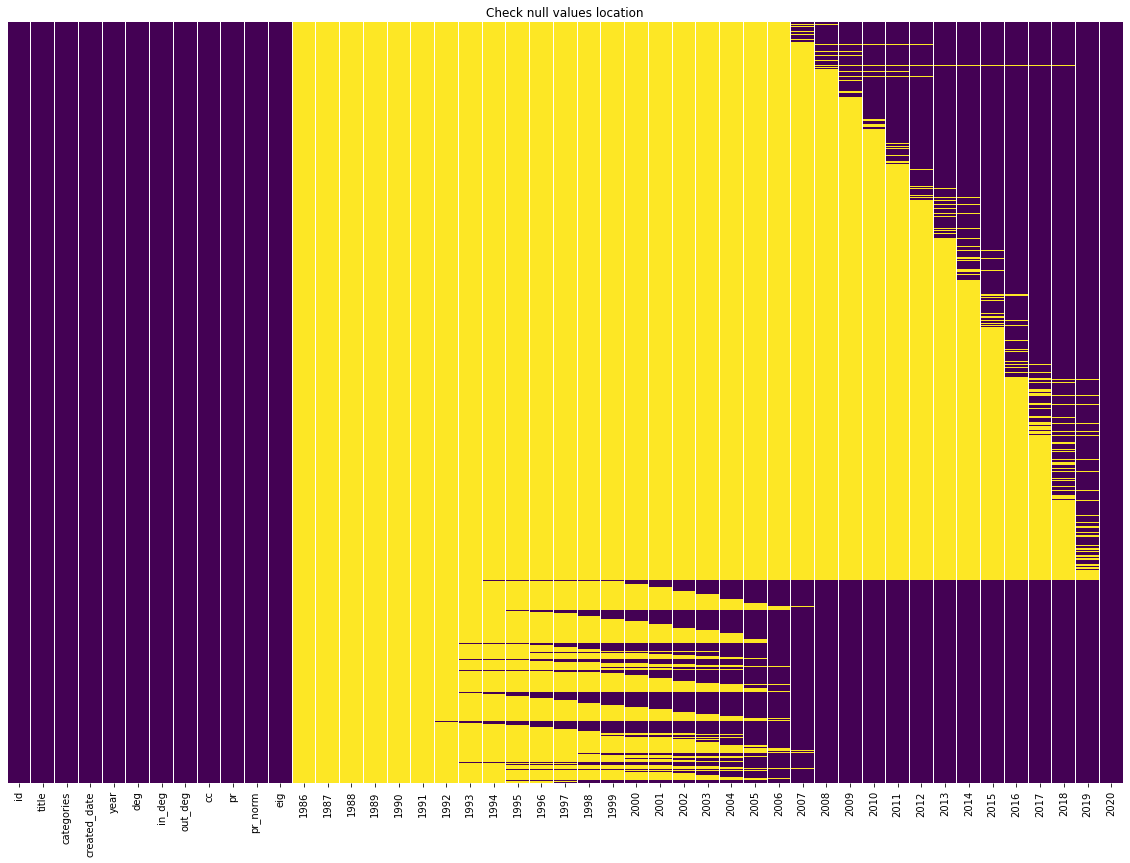

In [ ]:
plt.figure(figsize=(20,14))
sns.heatmap(paper.isnull(), 
            cmap = 'viridis', 
            yticklabels=False,
            cbar = False)
plt.title('Check null values location')
plt.show()

In [ ]:
created_year = paper['year'].value_counts().to_frame().sort_index().reset_index()
created_year.columns = ['year', 'total_paper']
created_year['cumsum'] = created_year['total_paper'].cumsum()
created_year.set_index('year', inplace = True)
created_year.head(10)

total_paper  cumsum
year                     
1986            1       1
1988            1       2
1989            1       3
1990            8      11
1991          238     249
1992         1864    2113
1993         3866    5979
1994         6026   12005
1995         8193   20198
1996        10822   31020

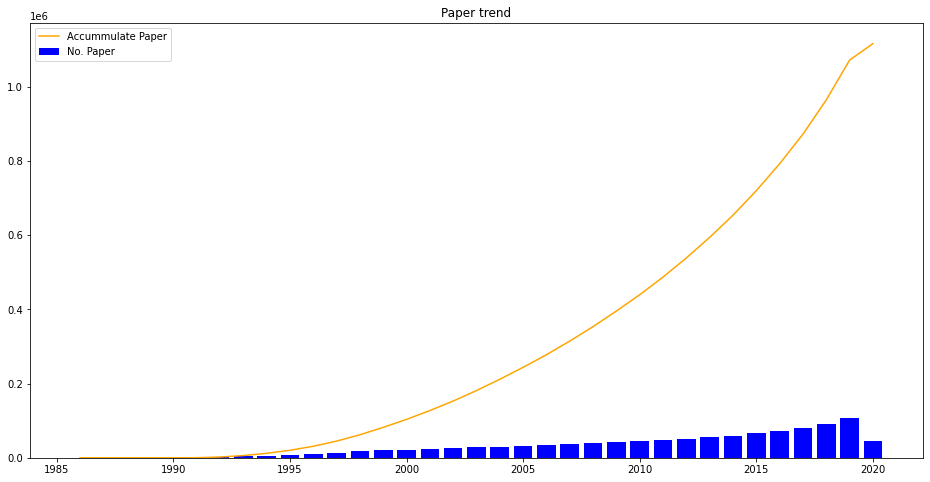

In [ ]:
# Paper Trend
fig, ax = plt.subplots( figsize = (16,8))
ax.plot(created_year['cumsum'], color = 'orange', label = 'Accummulate Paper')
ax.bar(created_year.index, created_year['total_paper'], color = 'blue', label  = 'No. Paper')
plt.title('Paper trend')
plt.legend()
plt.show()

In [ ]:
# get unique paper categories
unq_lst = []
for c in paper['categories'].unique():
  c = c.replace("'","").replace('[','').replace(']','')
  split_c = c.split(',')
  for w in split_c:
    unq_lst.append(w.strip())

unq_lst = set(unq_lst)

In [ ]:
print(f'Number of Unique categories : {len(unq_lst)}')
print(f'Example of Unique categories : {list(unq_lst)[:3]}')

Number of Unique categories : 176
Example of Unique categories : ['physics.ao-ph', 'math.MG', 'supr-con']


In [ ]:
unq_lst

{'acc-phys',
 'adap-org',
 'alg-geom',
 'ao-sci',
 'astro-ph',
 'astro-ph.CO',
 'astro-ph.EP',
 'astro-ph.GA',
 'astro-ph.HE',
 'astro-ph.IM',
 'astro-ph.SR',
 'atom-ph',
 'bayes-an',
 'chao-dyn',
 'chem-ph',
 'cmp-lg',
 'comp-gas',
 'cond-mat',
 'cond-mat.dis-nn',
 'cond-mat.mes-hall',
 'cond-mat.mtrl-sci',
 'cond-mat.other',
 'cond-mat.quant-gas',
 'cond-mat.soft',
 'cond-mat.stat-mech',
 'cond-mat.str-el',
 'cond-mat.supr-con',
 'cs.AI',
 'cs.AR',
 'cs.CC',
 'cs.CE',
 'cs.CG',
 'cs.CL',
 'cs.CR',
 'cs.CV',
 'cs.CY',
 'cs.DB',
 'cs.DC',
 'cs.DL',
 'cs.DM',
 'cs.DS',
 'cs.ET',
 'cs.FL',
 'cs.GL',
 'cs.GR',
 'cs.GT',
 'cs.HC',
 'cs.IR',
 'cs.IT',
 'cs.LG',
 'cs.LO',
 'cs.MA',
 'cs.MM',
 'cs.MS',
 'cs.NA',
 'cs.NE',
 'cs.NI',
 'cs.OH',
 'cs.OS',
 'cs.PF',
 'cs.PL',
 'cs.RO',
 'cs.SC',
 'cs.SD',
 'cs.SE',
 'cs.SI',
 'cs.SY',
 'dg-ga',
 'econ.EM',
 'econ.GN',
 'econ.TH',
 'eess.AS',
 'eess.IV',
 'eess.SP',
 'eess.SY',
 'funct-an',
 'gr-qc',
 'hep-ex',
 'hep-lat',
 'hep-ph',
 'hep-th',
 'm

In [ ]:
# main cat
main_cat_lst = []
for mc in unq_lst:
  mc = mc.split('.')[0]
  if mc not in main_cat_lst:
    main_cat_lst.append(mc)

In [ ]:
print(f'Number of Unique main categories : {len(main_cat_lst)}')
print(f'Example of Unique main categories : {list(main_cat_lst)[:3]}')

Number of Unique main categories : 38
Example of Unique main categories : ['physics', 'math', 'supr-con']


In [ ]:
main_cat_lst

['physics',
 'math',
 'supr-con',
 'q-bio',
 'funct-an',
 'cs',
 'stat',
 'q-fin',
 'hep-th',
 'econ',
 'math-ph',
 'gr-qc',
 'cond-mat',
 'hep-ex',
 'astro-ph',
 'chem-ph',
 'nlin',
 'quant-ph',
 'cmp-lg',
 'comp-gas',
 'eess',
 'alg-geom',
 'hep-lat',
 'ao-sci',
 'nucl-th',
 'bayes-an',
 'q-alg',
 'plasm-ph',
 'mtrl-th',
 'patt-sol',
 'solv-int',
 'atom-ph',
 'dg-ga',
 'hep-ph',
 'chao-dyn',
 'acc-phys',
 'adap-org',
 'nucl-ex']

# PageRank

In [ ]:
# time to popular
paper2 = paper[['id','title','year','1986', '1987', '1988', '1989','1990', 
                '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998','1999', '2000', 
                '2001', '2002', '2003', '2004', '2005', '2006', '2007','2008', '2009', '2010', 
                '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']].copy()

In [ ]:
popular_time = paper2.melt(id_vars = ['id','title','year'], var_name = 'pr_year', value_name = 'pr_score')
popular_time = popular_time[popular_time['pr_score'].notnull()]
popular_time['pr_year'] = popular_time['pr_year'].astype(int)
popular_time['period'] = popular_time['pr_year'] - popular_time['year']
popular_time.head()

id                             title  ...  pr_score  period
1095554  physics/9403001  Desperately Seeking Superstrings  ...       1.0       0
2211419  physics/9403001  Desperately Seeking Superstrings  ...       1.0       1
3256974   hep-th/9108028    Applied Conformal Field Theory  ...       1.0       0
3327284  physics/9403001  Desperately Seeking Superstrings  ...       1.0       2
4372839   hep-th/9108028    Applied Conformal Field Theory  ...       1.0       1

[5 rows x 6 columns]

In [ ]:
popular_time.shape

(10870231, 6)

In [ ]:
popular_time_pv = popular_time.pivot_table(index = 'year', columns = 'period', values = 'pr_score', aggfunc = 'mean')
popular_time_pv.head()

period   0         1         2   ...         32        33        34
year                             ...                               
1986    1.0  1.000000  1.000000  ...   1.076837  1.099948  1.101964
1988    1.0  1.000000  1.000000  ...  64.752111       NaN       NaN
1989    1.0  1.000000  1.000000  ...        NaN       NaN       NaN
1990    1.0  1.000000  1.000000  ...        NaN       NaN       NaN
1991    1.0  1.008137  1.059184  ...        NaN       NaN       NaN

[5 rows x 35 columns]

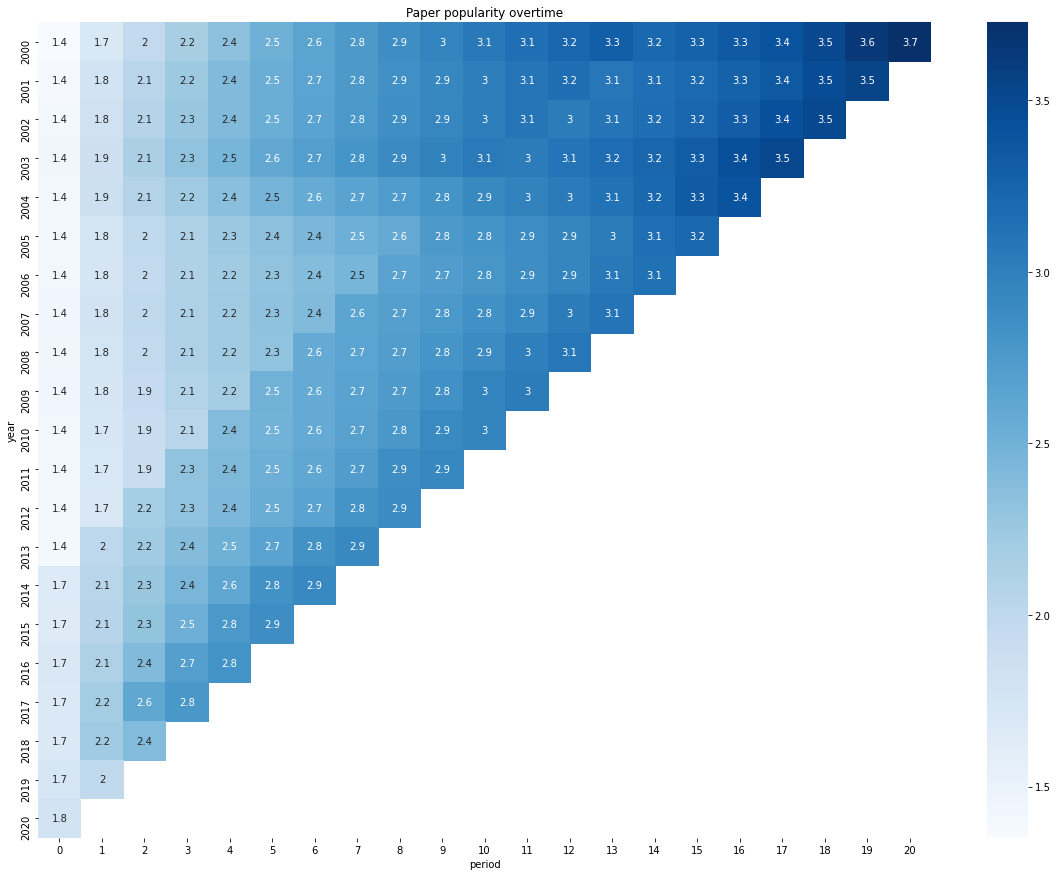

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(popular_time_pv.loc['2000':,:'20'], cmap = 'Blues', annot = True)
plt.title('Paper popularity overtime')
plt.show()

In [ ]:
popular_time[popular_time['year']<= 1989].sort_values(by='pr_score', ascending=False).head(10)

id                           title  ...   pr_score  period
38964654  hep-th/9108028  Applied Conformal Field Theory  ...  64.752111      32
37848789  hep-th/9108028  Applied Conformal Field Theory  ...  61.041940      31
36732924  hep-th/9108028  Applied Conformal Field Theory  ...  52.024866      30
35617059  hep-th/9108028  Applied Conformal Field Theory  ...  43.631360      29
34501194  hep-th/9108028  Applied Conformal Field Theory  ...  35.695635      28
33385329  hep-th/9108028  Applied Conformal Field Theory  ...  30.369399      27
32269464  hep-th/9108028  Applied Conformal Field Theory  ...  24.933177      26
31153599  hep-th/9108028  Applied Conformal Field Theory  ...  17.227663      25
30037734  hep-th/9108028  Applied Conformal Field Theory  ...  15.541307      24
28921869  hep-th/9108028  Applied Conformal Field Theory  ...  13.058922      23

[10 rows x 6 columns]

# Filter Only CS.

In [ ]:
paper.head()

id  ...      2020
0      704  ...  5.005640
1      704  ...  3.466352
2      704  ...  3.466352
3  704.001  ...  1.000000
4  704.001  ...  6.769744

[5 rows x 47 columns]

In [ ]:
cs_paper = paper[paper['categories'].apply(lambda x: True if 'cs.' in x else False)]
cs_paper.head()

id  ...      2020
1       704  ...  3.466352
2       704  ...  3.466352
25  704.003  ...  1.000000
27  704.004  ...  1.000000
29  704.004  ...  1.000000

[5 rows x 47 columns]

In [ ]:
# time to popular
paper2_cs = cs_paper[['id','title','year', '1994', '1995', '1996', '1997', '1998','1999', '2000', 
                '2001', '2002', '2003', '2004', '2005', '2006', '2007','2008', '2009', '2010', 
                '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']].copy()
# start at 1994
paper2_cs = paper2_cs[paper2_cs['year']>=1994]
popular_time_cs = paper2_cs.melt(id_vars = ['id','title','year'], var_name = 'pr_year', value_name = 'pr_score')
popular_time_cs = popular_time_cs[popular_time_cs['pr_score'].notnull()]
popular_time_cs['pr_year'] = popular_time_cs['pr_year'].astype(int)
popular_time_cs['period'] = popular_time_cs['pr_year'] - popular_time_cs['year']

popular_time_pv_cs = popular_time_cs.pivot_table(index = 'year', columns = 'period', values = 'pr_score', aggfunc = 'mean')
popular_time_pv_cs.head()


popular_time_pv_cs.head()

period        0         1         2   ...        24        25        26
year                                  ...                              
1994    1.078655  1.189474  1.241248  ...  2.273802  2.377086  2.411619
1995    1.064012  1.329132  1.435420  ...  4.112983  4.258522       NaN
1996    1.118145  1.265071  1.388804  ...  3.170070       NaN       NaN
1997    1.346696  1.692520  2.058285  ...       NaN       NaN       NaN
1998    1.296640  1.623824  1.819384  ...       NaN       NaN       NaN

[5 rows x 27 columns]

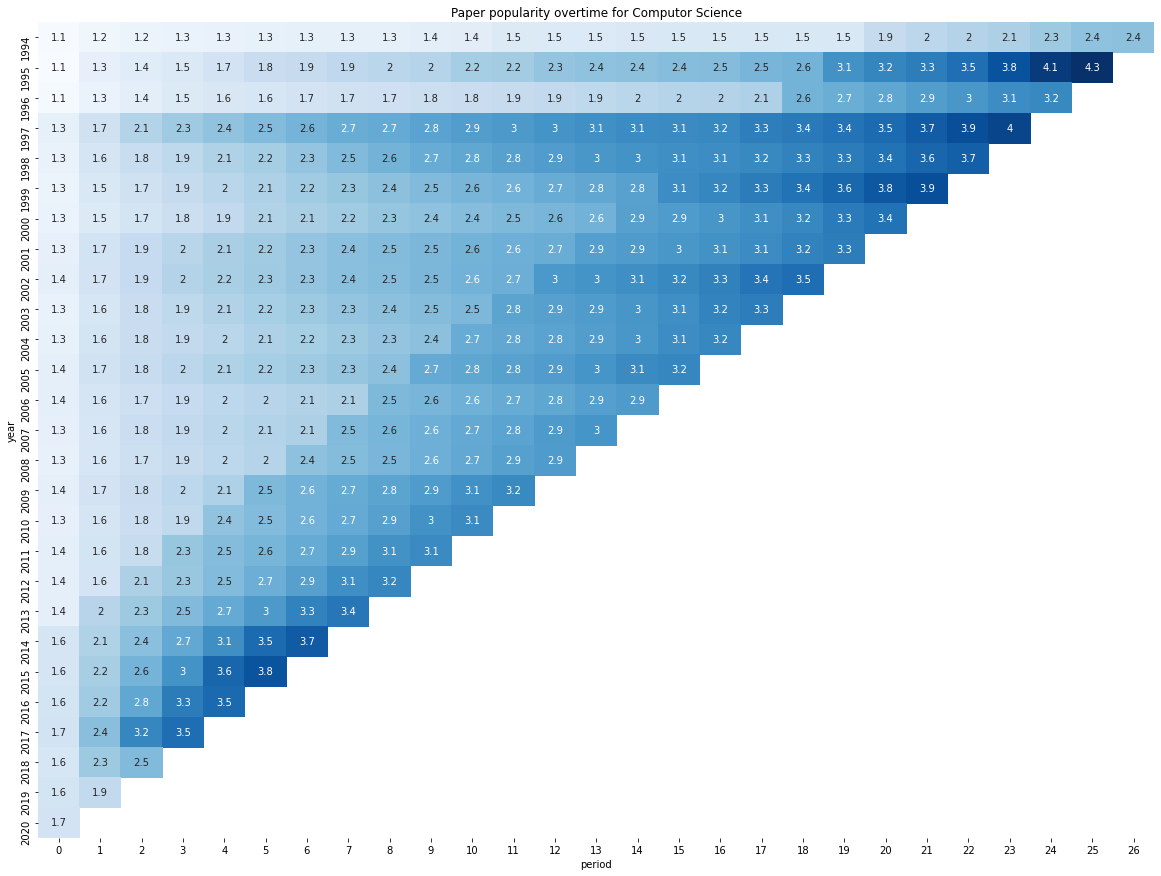

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(popular_time_pv_cs, cmap = 'Blues', annot = True, cbar = False)
plt.title('Paper popularity overtime for Computor Science')
plt.show()

In [ ]:
temp = popular_time_cs[popular_time_cs['year'] >= 2017].sort_values(by='pr_score', ascending = False).head(20)
temp[temp['pr_year'] == 2020].head(20)

id  ... period
5813747   1412.7  ...      3
5902757  1810.05  ...      1
5856665  1704.05  ...      3
5824562  1509.03  ...      1
5863394  1707.06  ...      3
5851175  1701.08  ...      3
5842986  1609.03  ...      3
5884329  1804.03  ...      2
5865885  1708.08  ...      3
5837851  1606.01  ...      3

[10 rows x 6 columns]

In [ ]:
temp = paper[(paper['year']>= 2017)& (paper['categories'].apply(lambda x: True if 'cs.' in x else False))]
temp.head()

id  ...       2020
4666   705.284  ...   3.466352
8864   706.418  ...   1.000000
11833  707.403  ...   1.000000
14276  708.296  ...   2.547820
16391  709.167  ...  18.269828

[5 rows x 47 columns]

In [ ]:
temp.sort_values(by='2020',ascending=False).head()

id  ...         2020
380719   1412.7  ...  6112.571446
679221  1810.05  ...   735.316701
547602  1704.05  ...   512.969213
428244  1509.03  ...   425.309476
569012  1707.06  ...   401.248691

[5 rows x 47 columns]

In [ ]:
for year in popular_time_cs['year'].unique():
  con1 = popular_time_cs['year'] == year
  con2 = popular_time_cs['pr_year'] == 2020
  temp2 = popular_time_cs[con1 & con2].sort_values(by='pr_score', ascending = False)
  print(f'-------------------------- was published in year {year}--------------------------------------------------')
  print()
  display(temp2.head())
  print()

-------------------------- was published in year 1994--------------------------------------------------



id  ... period
5965032   cmp-lg/9404008  ...     26
5968358       cs/9408103  ...     26
5965030   cmp-lg/9404002  ...     26
5965012  chem-ph/9411008  ...     26
5969536     math/9411235  ...     26

[5 rows x 6 columns]


-------------------------- was published in year 1995--------------------------------------------------



id  ... period
5969005    hep-ph/9512295  ...     25
5965092    cmp-lg/9511007  ...     25
5968360        cs/9501101  ...     25
5964976  chao-dyn/9505001  ...     25
5964549  acc-phys/9502001  ...     25

[5 rows x 6 columns]


-------------------------- was published in year 1996--------------------------------------------------



id  ... period
5969132   hep-th/9610193  ...     24
5968364       cs/9605103  ...     24
5976377  physics/9611001  ...     24
5969006   hep-ph/9610474  ...     24
5976371  physics/9610012  ...     24

[5 rows x 6 columns]


-------------------------- was published in year 1997--------------------------------------------------



id  ... period
5966199  cond-mat/9707301  ...     23
5976398   physics/9701026  ...     23
5965147    cmp-lg/9709008  ...     23
5966191  cond-mat/9705075  ...     23
5969008    hep-ph/9705432  ...     23

[5 rows x 6 columns]


-------------------------- was published in year 1998--------------------------------------------------



id  ... period
5977770  quant-ph/9802049  ...     22
5968691     gr-qc/9808081  ...     22
5968384        cs/9809099  ...     22
5968379        cs/9809032  ...     22
5964918  astro-ph/9803165  ...     22

[5 rows x 6 columns]


-------------------------- was published in year 1999--------------------------------------------------



id  ... period
5977744  quant-ph/9607014  ...     21
5976869   physics/9905030  ...     21
5968710     gr-qc/9911008  ...     21
5976514   physics/9711021  ...     21
5968811    hep-ex/9902006  ...     21

[5 rows x 6 columns]


-------------------------- was published in year 2000--------------------------------------------------



id  ... period
5970082   physics/0004057  ...     20
5970316   physics/0010042  ...     20
5966340        cs/0004001  ...     20
5966408        cs/0011047  ...     20
5977220  quant-ph/0011122  ...     20

[5 rows x 6 columns]


-------------------------- was published in year 2001--------------------------------------------------



id  ... period
5965298  cond-mat/0106096  ...     19
5968747    hep-ex/0108012  ...     19
5966395        cs/0010035  ...     19
5977255  quant-ph/0108033  ...     19
5966345        cs/0004015  ...     19

[5 rows x 6 columns]


-------------------------- was published in year 2002--------------------------------------------------



id  ... period
5970962   physics/0204033  ...     18
5966198  cond-mat/9707221  ...     18
5977311  quant-ph/0205083  ...     18
5966596        cs/0205028  ...     18
5969617      nlin/0211049  ...     18

[5 rows x 6 columns]


-------------------------- was published in year 2003--------------------------------------------------



id  ... period
5966907        cs/0310049  ...     17
5971697   physics/0306116  ...     17
5971838   physics/0308063  ...     17
5971652   physics/0306031  ...     17
5977366  quant-ph/0303081  ...     17

[5 rows x 6 columns]


-------------------------- was published in year 2004--------------------------------------------------



id  ... period
5966843       cs/0308002  ...     16
5966870       cs/0309027  ...     16
5972547  physics/0406120  ...     16
5972632  physics/0407137  ...     16
5967160       cs/0411099  ...     16

[5 rows x 6 columns]


-------------------------- was published in year 2005--------------------------------------------------



id  ... period
5967574       cs/0512078  ...     15
5973201  physics/0503046  ...     15
5974237  physics/0511182  ...     15
5972253  physics/0402083  ...     15
5968526    gr-qc/0104064  ...     15

[5 rows x 6 columns]


-------------------------- was published in year 2006--------------------------------------------------



id  ... period
5974911   physics/0605038  ...     14
5965785  cond-mat/0412004  ...     14
5975399   physics/0608255  ...     14
5966694        cs/0212002  ...     14
5965979  cond-mat/0601420  ...     14

[5 rows x 6 columns]


-------------------------- was published in year 2007--------------------------------------------------



id  ... period
5756586           704.191  ...     13
5756704           705.001  ...     13
5758696           712.195  ...     13
5977447  quant-ph/0402130  ...     13
5976137   physics/0702033  ...     13

[5 rows x 6 columns]


-------------------------- was published in year 2008--------------------------------------------------



id  ... period
5761748  810.135  ...     12
5758480   711.32  ...     12
5759497  803.048  ...     12
5762387  812.105  ...     12
5761542  809.323  ...     12

[5 rows x 6 columns]


-------------------------- was published in year 2009--------------------------------------------------



id  ... period
5976257  physics/0703039  ...     11
5757008          706.106  ...     11
5762439          812.177  ...     11
5758193          710.326  ...     11
5765061          907.367  ...     11

[5 rows x 6 columns]


-------------------------- was published in year 2010--------------------------------------------------



id  ... period
5773136  1012.26  ...     10
5772367  1011.04  ...     10
5771136  1008.47  ...     10
5773220  1012.38  ...     10
5768833  1004.25  ...     10

[5 rows x 6 columns]


-------------------------- was published in year 2011--------------------------------------------------



id  ... period
5772602   1011.3  ...      9
5780163  1111.45  ...      9
5774171  1102.15  ...      9
5767519  1001.34  ...      9
5780139  1111.42  ...      9

[5 rows x 6 columns]


-------------------------- was published in year 2012--------------------------------------------------



id  ... period
5790410  1212.57  ...      8
5785824  1207.06  ...      8
5789822  1212.04  ...      8
5787855  1209.51  ...      8
5772238  1010.51  ...      8

[5 rows x 6 columns]


-------------------------- was published in year 2013--------------------------------------------------



id  ... period
5790994  1301.38  ...      7
5801153  1312.56  ...      7
5771655  1009.51  ...      7
5798142  1309.42  ...      7
5798787  1310.15  ...      7

[5 rows x 6 columns]


-------------------------- was published in year 2014--------------------------------------------------



id  ... period
5801221  1312.61  ...      6
5809303  1408.51  ...      6
5806693  1406.11  ...      6
5811941  1411.18  ...      6
5813231  1412.36  ...      6

[5 rows x 6 columns]


-------------------------- was published in year 2015--------------------------------------------------



id  ... period
5809719  1409.16  ...      5
5815572  1502.03  ...      5
5828942  1512.03  ...      5
5816728  1503.03  ...      5
5813654  1412.66  ...      5

[5 rows x 6 columns]


-------------------------- was published in year 2016--------------------------------------------------



id  ... period
5809599  1409.05  ...      4
5833416  1603.04  ...      4
5827901  1511.06  ...      4
5843846  1609.08  ...      4
5836453  1605.03  ...      4

[5 rows x 6 columns]


-------------------------- was published in year 2017--------------------------------------------------



id  ... period
5813747   1412.7  ...      3
5856665  1704.05  ...      3
5863394  1707.06  ...      3
5851175  1701.08  ...      3
5842986  1609.03  ...      3

[5 rows x 6 columns]


-------------------------- was published in year 2018--------------------------------------------------



id  ... period
5884329  1804.03  ...      2
5860546  1706.03  ...      2
5842198  1608.07  ...      2
5847361  1611.07  ...      2
5890311  1806.01  ...      2

[5 rows x 6 columns]


-------------------------- was published in year 2019--------------------------------------------------



id  ... period
5902757  1810.05  ...      1
5824562  1509.03  ...      1
5795238  1306.21  ...      1
5879146  1802.04  ...      1
5861251  1706.06  ...      1

[5 rows x 6 columns]


-------------------------- was published in year 2020--------------------------------------------------



id  ... period
5855509  1703.11  ...      0
5878911  1802.03  ...      0
5932147  1906.08  ...      0
5887704  1805.05  ...      0
5905197  1811.01  ...      0

[5 rows x 6 columns]

In [ ]:
popular_time_cs.head()

id  ... period
208096  acc-phys/9411002  ...      0
208556   chem-ph/9403003  ...      0
208557   chem-ph/9403005  ...      0
208558   chem-ph/9404003  ...      0
208559   chem-ph/9411007  ...      0

[5 rows x 6 columns]

# Keywords over year

In [ ]:
def text_prep(df, col):
  from nltk.tokenize import word_tokenize
  import nltk
  nltk.download('punkt')
  nltk.download('stopwords')
  nltk.download('wordnet')
  from nltk.tokenize import word_tokenize
  from nltk.corpus import stopwords
  from nltk.stem import WordNetLemmatizer
  
   
  df_clean = df.copy()
  col_new = col+'_new'

  # make lower case
  df_clean[col_new] = df_clean[col].str.lower()

  # remove punctuation
  df_clean[col_new] = df_clean[col_new].str.replace('[^\w\s]','')

  # text tokenization
  df_clean[col_new] = df_clean[col_new].apply(word_tokenize)

  # create lst of English stopwords
  stop_words = stopwords.words('english') 

  # remove stopwords from tokenize
  df_clean['tokenize'] = df_clean[col_new].apply(lambda x: [ word for word in x if word not in stop_words and word[0].isalpha() ])

  # lemmatizing
  lemmatizer = WordNetLemmatizer() 
  df_clean['tokenize'] = df_clean['tokenize'].apply(lambda x: [ lemmatizer.lemmatize(word) for word in x ] )
  df_clean.drop(columns = col_new, inplace = True)

  return df_clean

In [ ]:
paper = pd.read_csv('/content/drive/My Drive/Big Data Analytics & Social/graph_stat_1M_pageranks.csv', dtype = {'id':'str'})
cs_paper = paper[paper['categories'].apply(lambda x: True if 'cs.' in x else False)]
cs_paper.head()

id  ...      2020
1   0704.0002  ...  3.466352
2   0704.0003  ...  3.466352
25  0704.0033  ...  1.000000
27  0704.0035  ...  1.000000
29  0704.0037  ...  1.000000

[5 rows x 47 columns]

In [ ]:
# get top 20 paper overyear sorted by pr
cs_paper2 = cs_paper[['id','title','year','2020']]
top_paper = pd.DataFrame()
for year in cs_paper2['year'].unique():
  temp = cs_paper2[cs_paper2['year']==year].sort_values(by='2020', ascending=False).head(3)
  top_paper = pd.concat([top_paper,temp])
top_paper.head()  

id  ...       2020
59412  0810.1355  ...  62.675518
24679  0711.3199  ...  38.840892
35558  0803.0476  ...  37.737264
1314   0704.1908  ...  96.189783
2736   0705.0010  ...  74.438275

[5 rows x 4 columns]

In [ ]:
for i in top_paper.sort_values(by='2020', ascending=False).head(10)['title']:
  print(i)

Adam: A Method for Stochastic Optimization
Very Deep Convolutional Networks for Large-Scale Image Recognition
Efficient Estimation of Word Representations in Vector Space
Neural Machine Translation by Jointly Learning to Align and Translate
Batch Normalization: Accelerating Deep Network Training by Reducing
  Internal Covariate Shift
Auto-Encoding Variational Bayes
Caffe: Convolutional Architecture for Fast Feature Embedding
ADADELTA: An Adaptive Learning Rate Method
Deep Residual Learning for Image Recognition
BERT: Pre-training of Deep Bidirectional Transformers for Language
  Understanding


In [ ]:
top_10_title = top_paper.sort_values(by='2020', ascending=False).head(10)['title']
top_10_title

380719           Adam: A Method for Stochastic Optimization
360795    Very Deep Convolutional Networks for Large-Sca...
264525    Efficient Estimation of Word Representations i...
360082    Neural Machine Translation by Jointly Learning...
389162    Batch Normalization: Accelerating Deep Network...
318747                      Auto-Encoding Variational Bayes
358513    Caffe: Convolutional Architecture for Fast Fea...
261381           ADADELTA: An Adaptive Learning Rate Method
446936         Deep Residual Learning for Image Recognition
679221    BERT: Pre-training of Deep Bidirectional Trans...
Name: title, dtype: object

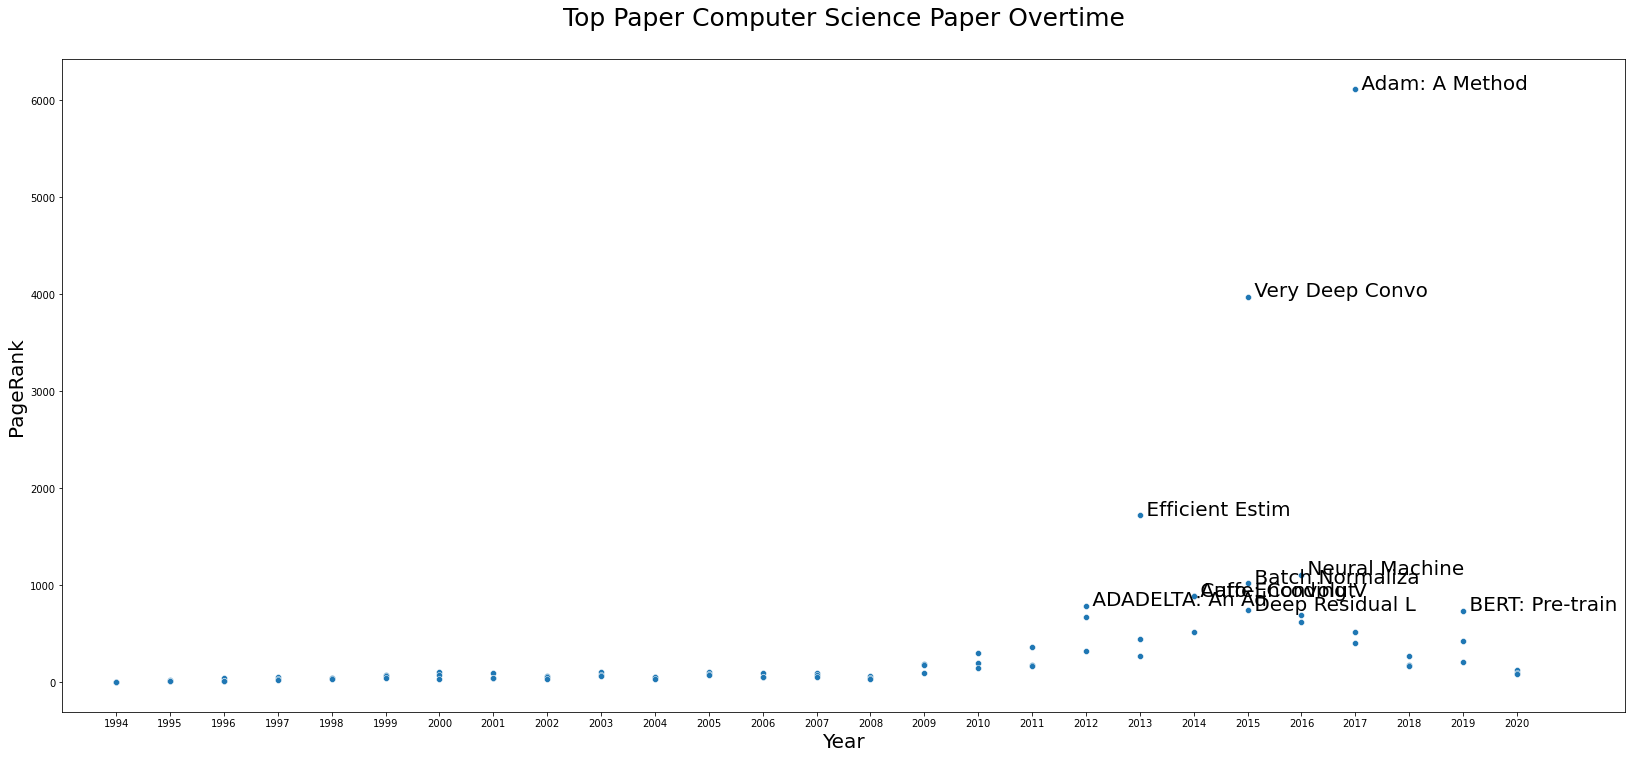

In [ ]:
fig, ax = plt.subplots(figsize=(28,12))
sns.scatterplot(x='year', y='2020', data = top_paper, ax = ax)
for idx in top_10_title.index:
  ax.annotate(f" {top_paper.loc[idx, 'title'][:15]}",
              xy=(top_paper.loc[idx, 'year'], top_paper.loc[idx,'2020']),
              size=20)
plt.title('Top Paper Computer Science Paper Overtime\n',fontsize=25)
plt.xticks(top_paper['year'].unique())
plt.ylabel('PageRank',size=20)
plt.xlabel('Year', size=20)
plt.xlim(1993,2022)
plt.show()

In [ ]:
top_paper.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 59412 to 1095554
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      541 non-null    object 
 1   title   541 non-null    object 
 2   year    541 non-null    int64  
 3   2020    541 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 21.1+ KB


In [ ]:
top_paper_tt = top_paper[['id','title']]
title_clean = text_prep(top_paper_tt, col = 'title')
title_clean['tokenize'] = title_clean['tokenize'].apply(lambda x: ' '.join(x))
title_clean.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


id  ...                                           tokenize
59412  0810.1355  ...  community structure large network natural clus...
24679  0711.3199  ...  analyzing modeling realworld phenomenon comple...
35558  0803.0476  ...             fast unfolding community large network
66441  0812.1045  ...           social network matter twitter microscope
57054  0809.3232  ...  local clustering algorithm massive graph appli...

[5 rows x 3 columns]

In [ ]:
title_clean.shape

(541, 3)

In [ ]:
vectorizer = TfidfVectorizer()
bow_df = vectorizer.fit_transform(title_clean['tokenize'])
bow_df = pd.DataFrame(bow_df.toarray() , columns = vectorizer.get_feature_names())
bow_df['id'] = top_paper['id'].values
bow_df_melt = bow_df.melt(id_vars = 'id', var_name= 'word', value_name= 'tfidf')
bow_df_melt = bow_df_melt[bow_df_melt['tfidf'] > 0 ]
bow_df_melt.shape

(3123, 3)

In [ ]:
bow_df_melt.head()

id        word     tfidf
382         cs/0010035     aadebug  0.389020
461         cs/0309027     aadebug  0.393060
864     hep-ph/9610474        able  0.357763
1082         0810.1355     absence  0.305793
2018  astro-ph/0012419  absorption  0.319446

In [ ]:
bow_df_melt_info = bow_df_melt.merge(top_paper, how = 'left', on = 'id')
bow_df_melt_info.head()

id        word  ...  year       2020
0        cs/0010035     aadebug  ...  2001  40.461638
1        cs/0309027     aadebug  ...  2004  53.409988
2    hep-ph/9610474        able  ...  1996  13.130416
3         0810.1355     absence  ...  2008  62.675518
4  astro-ph/0012419  absorption  ...  2001  14.948478

[5 rows x 6 columns]

In [ ]:
bow_df_melt_info['tfidf_pr'] = bow_df_melt_info['tfidf'] * bow_df_melt_info['2020']
bow_df_melt_info.head()

id        word     tfidf  ...  year       2020   tfidf_pr
0        cs/0010035     aadebug  0.389020  ...  2001  40.461638  15.740383
1        cs/0309027     aadebug  0.393060  ...  2004  53.409988  20.993344
2    hep-ph/9610474        able  0.357763  ...  1996  13.130416   4.697576
3         0810.1355     absence  0.305793  ...  2008  62.675518  19.165737
4  astro-ph/0012419  absorption  0.319446  ...  2001  14.948478   4.775231

[5 rows x 7 columns]

In [ ]:
top_word = pd.DataFrame()
for year in bow_df_melt_info['year'].unique():
  temp = bow_df_melt_info[bow_df_melt_info['year']==year].sort_values(by='tfidf_pr', ascending=False).head(20)
  top_word = pd.concat([top_word,temp])
top_word

id         word     tfidf  ...  year       2020   tfidf_pr
430   cond-mat/0106096      complex  0.588735  ...  2001  98.581048  58.038095
1662  cond-mat/0106096     mechanic  0.572245  ...  2001  98.581048  56.412475
2674  cond-mat/0106096  statistical  0.465428  ...  2001  98.581048  45.882332
1884  cond-mat/0106096      network  0.330613  ...  2001  98.581048  32.592128
2809    hep-ex/0108012        tesla  0.629491  ...  2001  41.366259  26.039686
...                ...          ...       ...  ...   ...        ...        ...
1162   physics/0607154          gld  0.530726  ...  2006  21.560392  11.442667
796    physics/0607154     document  0.530726  ...  2006  21.560392  11.442667
730    physics/9403001  desperately  0.577350  ...  1986   1.101964   0.636219
2494   physics/9403001      seeking  0.577350  ...  1986   1.101964   0.636219
2737   physics/9403001  superstring  0.577350  ...  1986   1.101964   0.636219

[543 rows x 7 columns]

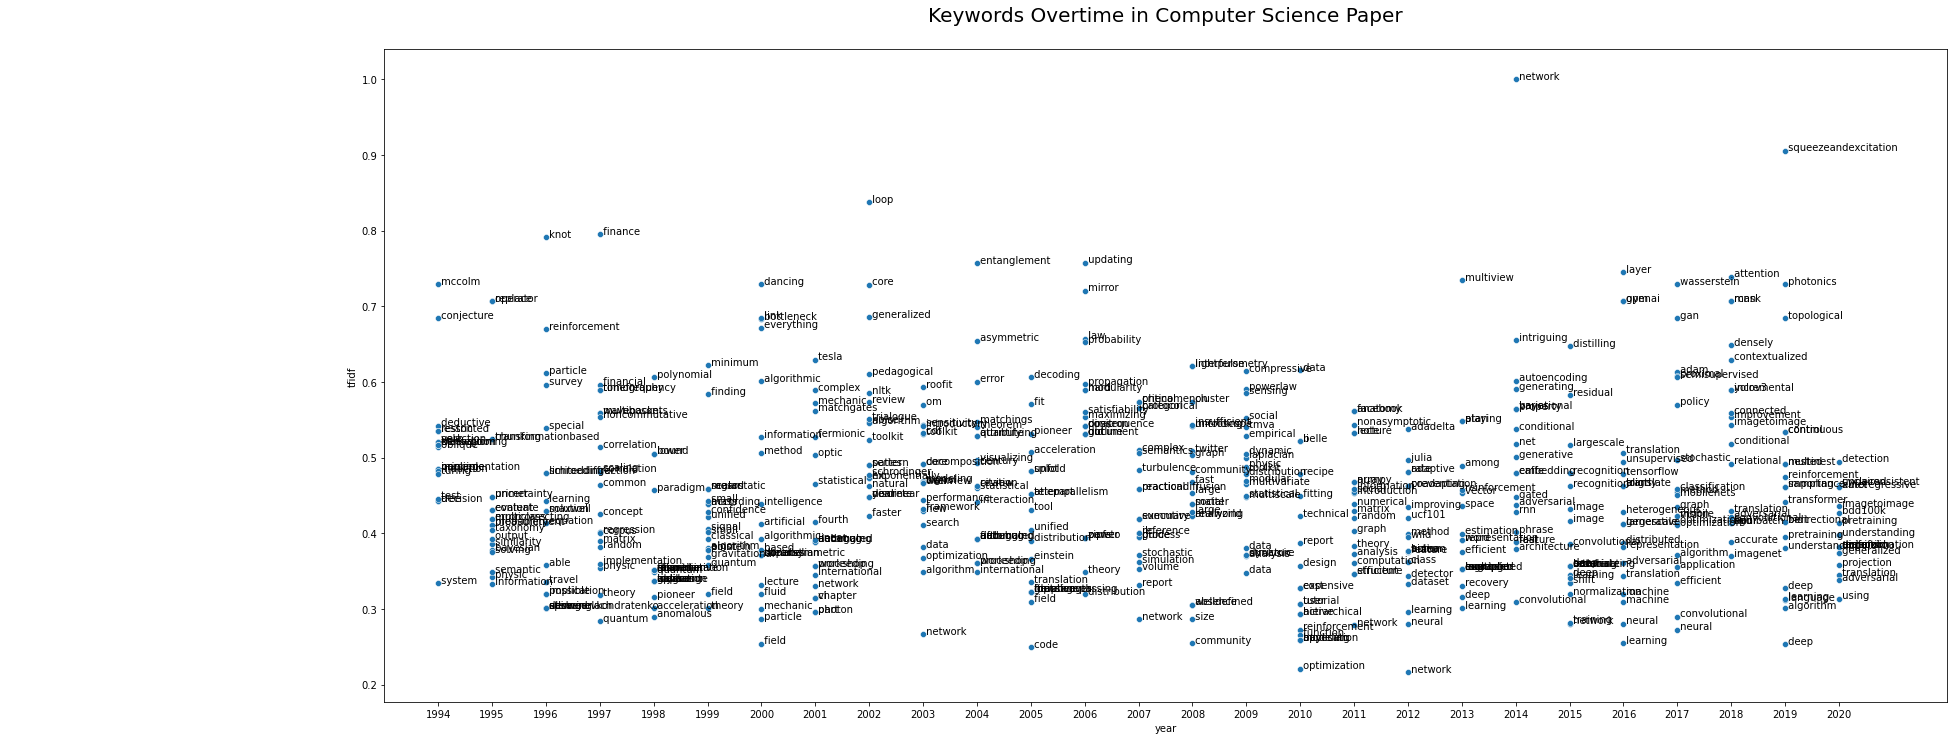

In [ ]:
fig, ax = plt.subplots(figsize=(28,12))
sns.scatterplot(x='year', y='tfidf', data = top_word, ax = ax)
for idx in top_word.index:
  ax.annotate(f" {top_word.loc[idx, 'word']}",
              xy=(top_word.loc[idx, 'year'], top_word.loc[idx,'tfidf']) )
plt.title('Keywords Overtime in Computer Science Paper\n',fontsize=20)
plt.xticks(top_word['year'].unique())
plt.xlim(1993,2022)
plt.show()

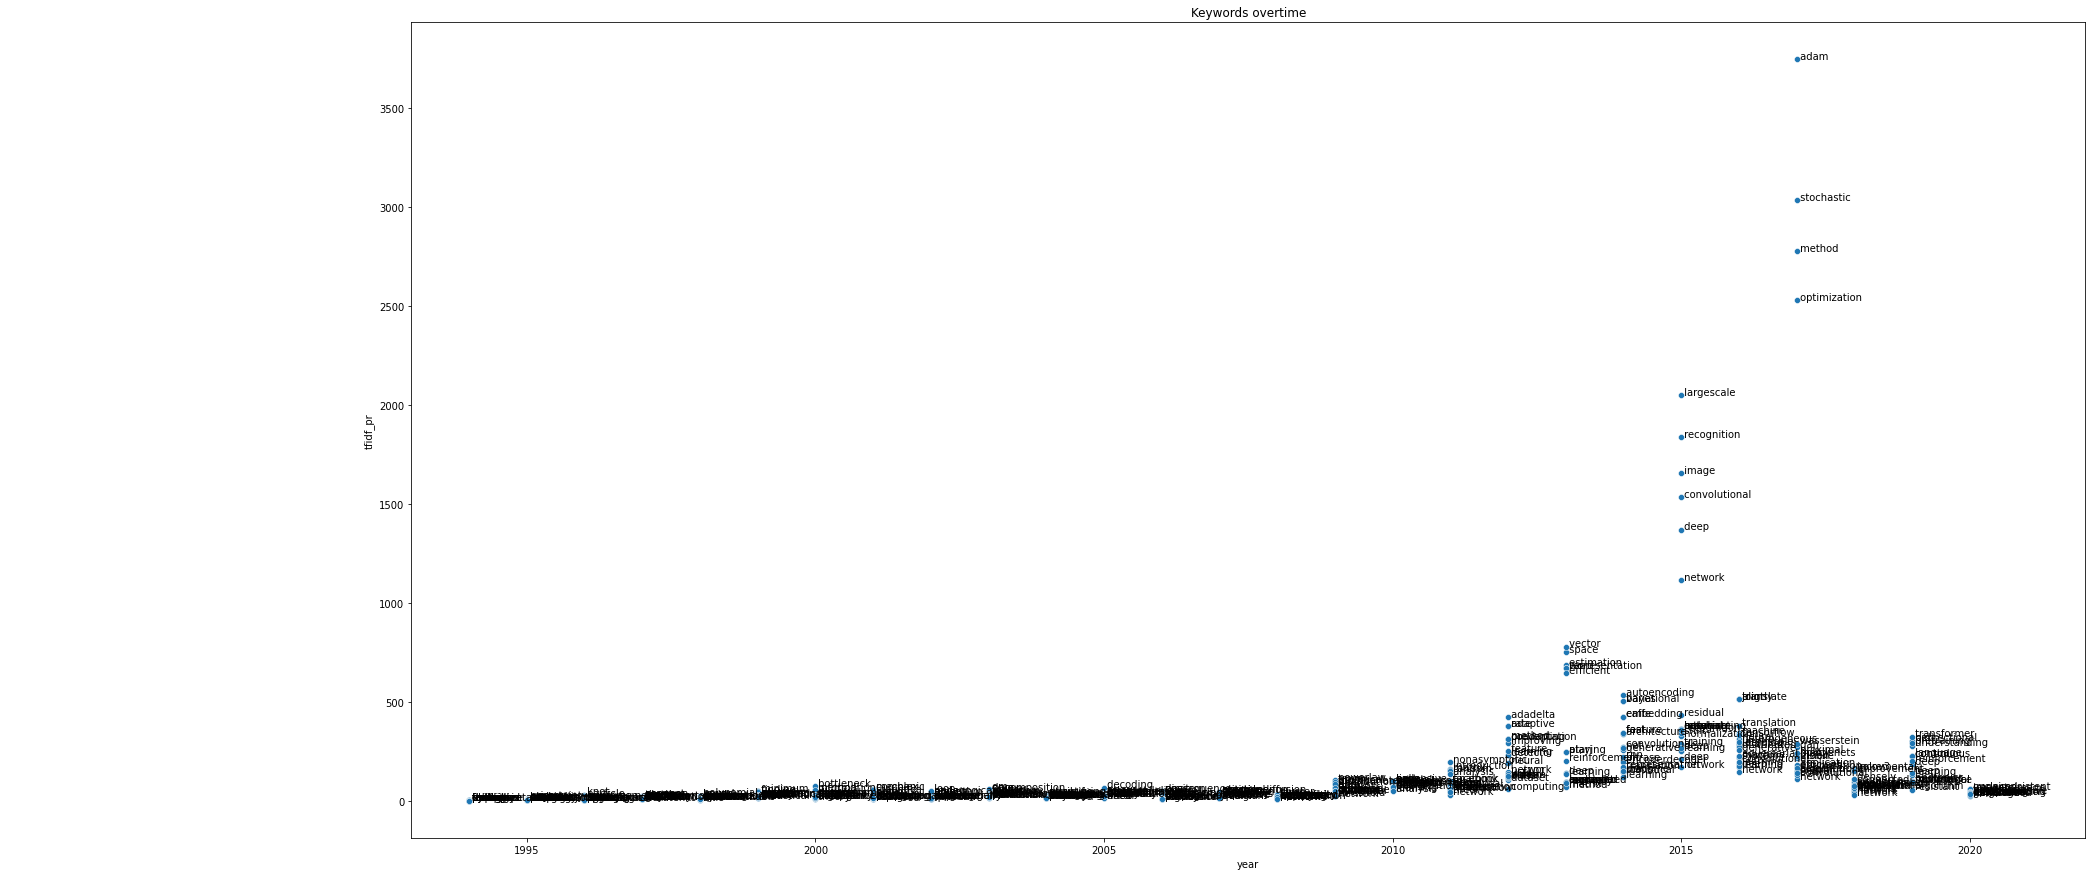

In [ ]:
fig, ax = plt.subplots(figsize=(30,15))
sns.scatterplot(x='year', y='tfidf_pr', data = top_word, ax = ax)
for idx in top_word.index:
  ax.annotate(f" {top_word.loc[idx, 'word']}",
              xy=(top_word.loc[idx, 'year'], top_word.loc[idx,'tfidf_pr']) )
plt.title('Keywords overtime')
plt.xlim(1993,2022)
plt.show()

# Community Detection

In [ ]:
paper = pd.read_csv('/content/drive/My Drive/Big Data Analytics & Social/graph_stat_1M_pageranks.csv', dtype = {'id':str})
cs_df = pd.read_csv('/content/drive/My Drive/Big Data Analytics & Social/SI_cosine_cut.csv', dtype = {'doc1':str,'doc2':str})
cs_df.head()

doc1       doc2    cosine
0  0710.4982  0806.4168  0.169031
1  0710.4982  1007.2876  0.142857
2  0710.4982  1008.2005  0.154303
3  0710.4982  1009.0119  0.133631
4  0710.4982  1010.3003  0.169031

In [ ]:
thres = 0.5
cs_df05 = cs_df[cs_df['cosine']>=0.5]
#get doc name
cs_df05 = cs_df05.merge(paper[['id','title']], left_on ='doc1', right_on = 'id', how='left')
cs_df05 = cs_df05.merge(paper[['id','title']], left_on ='doc2', right_on = 'id', how='left')
cs_df05.head()

doc1  ...                                            title_y
0  0806.4168  ...                       Compressive Network Analysis
1  0806.4168  ...                       Clustering Evolving Networks
2  0806.4168  ...  Motif Clustering and Overlapping Clustering fo...
3  0806.4168  ...                Higher-order clustering in networks
4  0806.4168  ...  Social Network Analysis: Bibliographic Network...

[5 rows x 7 columns]

In [ ]:
cs_df05.drop(columns = ['id_x','id_y'],inplace=True)
cs_df05.columns = ['doc1','doc2', 'cosine', 'title_doc1', 'title_doc2']

In [ ]:
unq_doc1 = list(cs_df05['doc1'].unique())
unq_doc2 = list(cs_df05['doc2'].unique())
unq_alldoc = list(set(unq_doc1 + unq_doc2))

In [ ]:
def filter_thres_plot(df, thres=0.5):
  df = df[df['cosine']>=thres]
  plt.figure(figsize=(12,12))

  G=nx.MultiGraph()
  G.add_nodes_from(unq_alldoc)

  for d1, d2, cs in zip(df['doc1'],df['doc2'],df['cosine']):
    G.add_edge(d1, d2, weight=cs)
  d = dict(G.degree)
  
  plt.title(f'Paper title similarity cosine >= {thres}')
  nx.draw_networkx_nodes(G,
                        pos=nx.spring_layout(G),
                        node_size=[v * 100 for v in d.values()], 
                        alpha = 0.3)

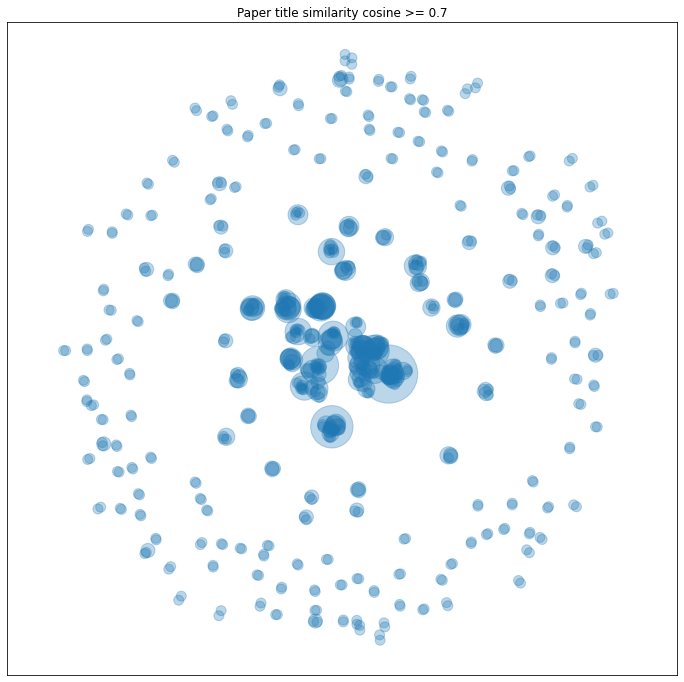

In [ ]:
filter_thres_plot(cs_df, thres = 0.7)

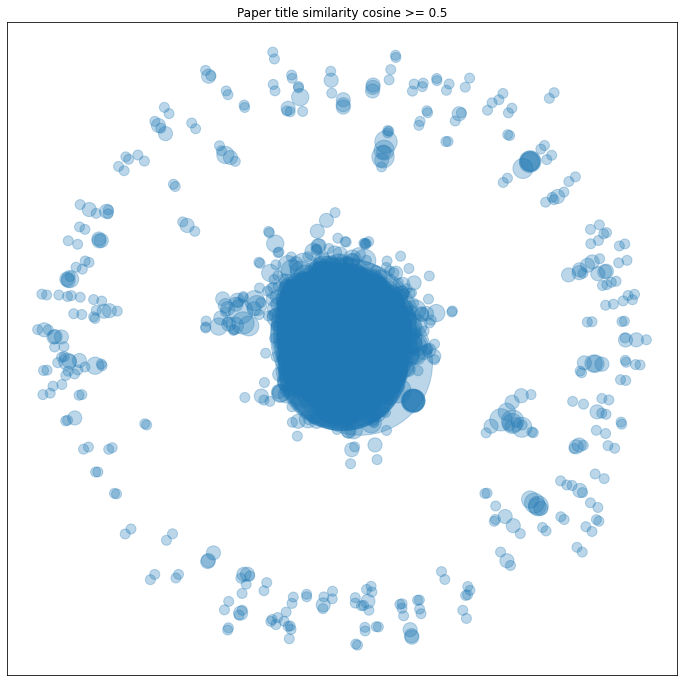

In [ ]:
filter_thres_plot(cs_df, thres = 0.5)

Name: Paper Community Detection cosine sim >= 0.7
Type: Graph
Number of nodes: 663
Number of edges: 576
Average degree:   1.7376


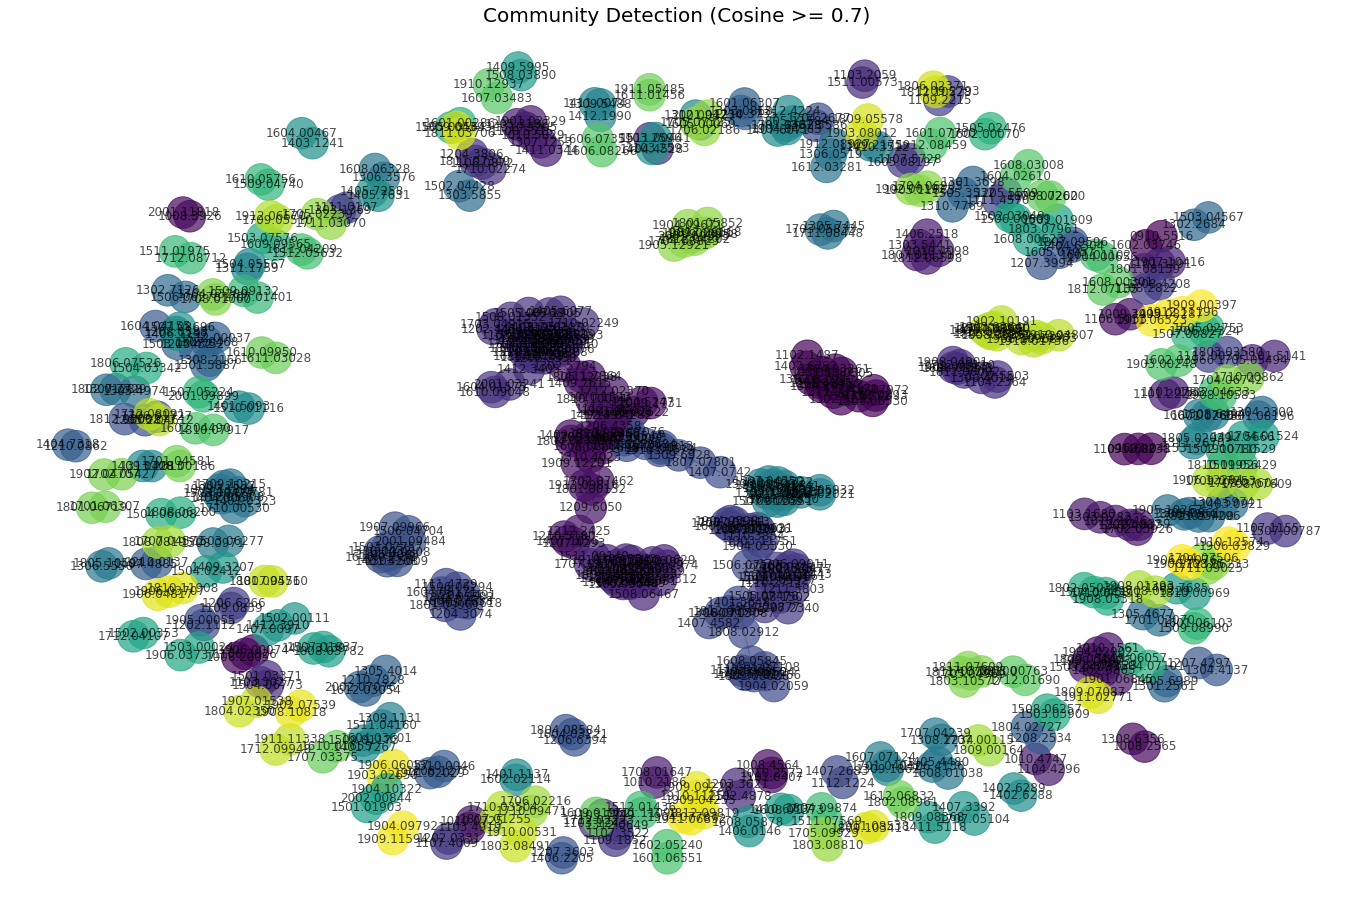

In [ ]:
thres = 0.7
temp_df = cs_df[cs_df['cosine']>=thres]
G = nx.convert_matrix.from_pandas_edgelist(temp_df, source='doc1', target='doc2')
G.name = f'Paper Community Detection cosine sim >= {thres}'
print(nx.info(G))


partition = community.best_partition(G, random_state=0)
position = nx.spring_layout(G)
values = [partition.get(node) for node in G.nodes()]
plt.figure(figsize=(24,16))
nx.draw_networkx(G,
                 position,
                 cmap=plt.get_cmap('viridis'),
                 arrows=True,
                 node_color=values, 
                 edge_color='grey',
                 node_size=1000, 
                 with_labels=True, 
                 alpha = 0.7,
                 font_weight='normal')
plt.title(f'Community Detection (Cosine >= {thres})', size=20)
plt.axis('off')
plt.show()

In [ ]:
partition.items()

dict_items([('0806.4168', 0), ('1104.4605', 1), ('1401.3516', 0), ('1612.00895', 0), ('1704.03913', 0), ('1812.05908', 2), ('0807.1550', 1), ('0809.2768', 1), ('1907.07175', 1), ('0906.0060', 3), ('1008.2565', 3), ('1102.2166', 2), ('1210.0808', 3), ('1308.6356', 3), ('1410.7833', 3), ('1503.07757', 3), ('1702.05427', 2), ('0906.4675', 0), ('1310.3521', 0), ('1610.09048', 1), ('1704.01524', 4), ('1803.06031', 0), ('1908.02520', 0), ('1909.06073', 5), ('0910.5516', 4), ('1010.1523', 4), ('1011.3315', 4), ('1012.2363', 4), ('1103.2596', 4), ('1109.2215', 4), ('1112.1831', 4), ('1205.1997', 4), ('1210.3735', 4), ('1303.0868', 4), ('1305.2006', 4), ('1310.4023', 4), ('1409.7615', 6), ('1411.7864', 7), ('1412.4973', 2), ('1509.06633', 4), ('1601.06307', 4), ('1602.03746', 4), ('1603.05566', 7), ('1605.02288', 4), ('1607.01683', 4), ('1612.02463', 4), ('1709.03135', 4), ('1712.04282', 7), ('1810.05511', 4), ('1909.12201', 4), ('0912.0238', 8), ('1109.4680', 8), ('1603.04153', 8), ('1001.3181

In [ ]:
paper_cluster = pd.DataFrame({'id' : list(partition.keys()),
                            'cluster' : list(partition.values())})

gb_pp_cluster = paper_cluster.groupby('cluster').count()
gb_pp_cluster.columns = ['n_paper']

#filter n paper in cummunity >= thres
thres_paper = 10
gb_pp_cluster = gb_pp_cluster[gb_pp_cluster['n_paper']>= thres_paper]
print(len(gb_pp_cluster))
index_cluster = gb_pp_cluster.index

17


In [ ]:
filtered_paper = paper_cluster[paper_cluster['cluster'].isin(index_cluster)]
filtered_paper.head()

id  cluster
0   0806.4168        0
1   1104.4605        1
2   1401.3516        0
3  1612.00895        0
4  1704.03913        0

Name: Paper Community Detection cosine sim >= 0.7
Type: Graph
Number of nodes: 192
Number of edges: 245
Average degree:   2.5521


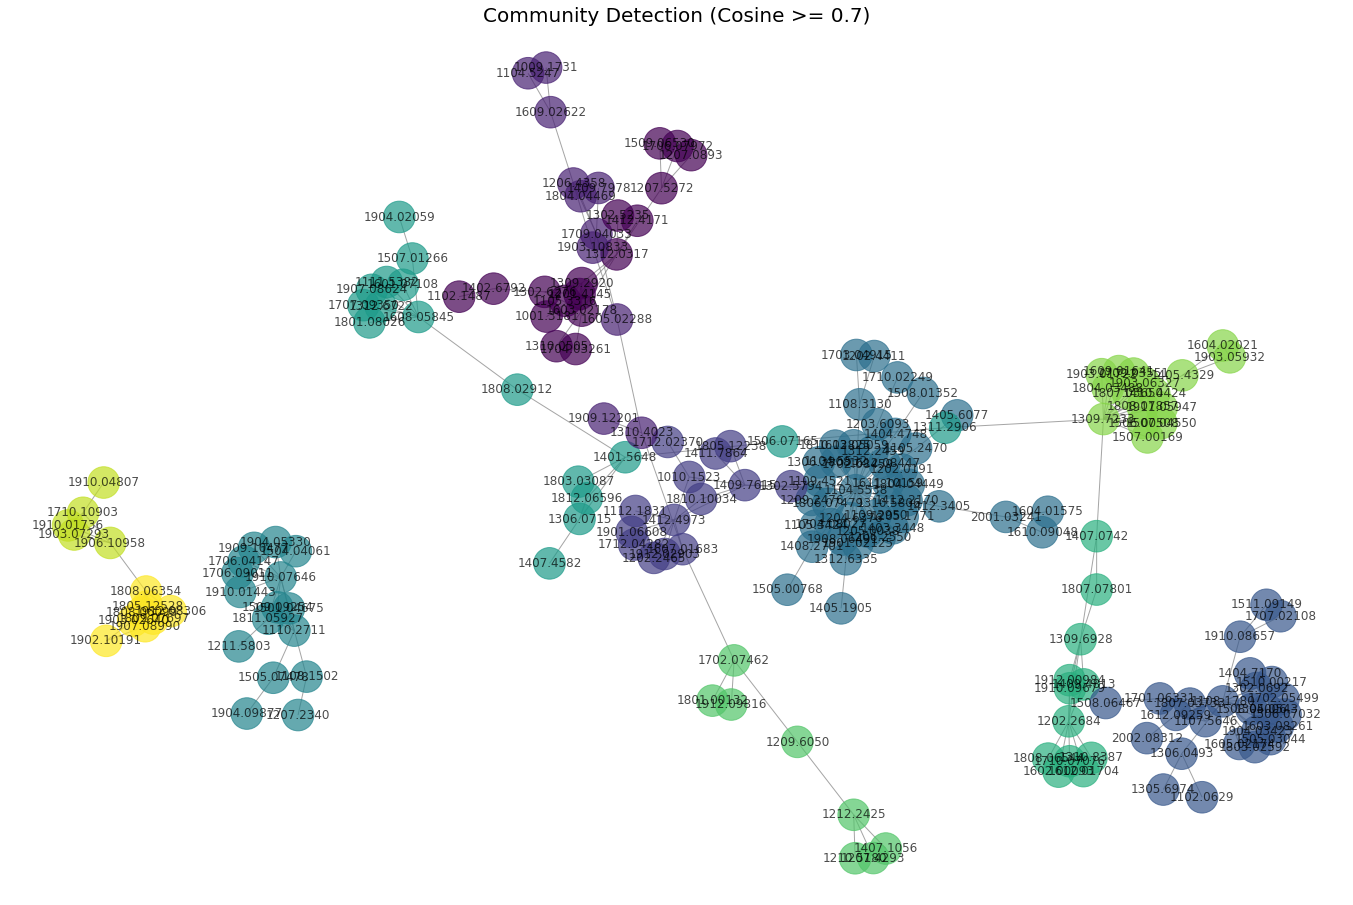

In [ ]:
thres = 0.7
con1 = cs_df['cosine']>=thres
con2 = cs_df['doc1'].isin(filtered_paper['id'])
con3 = cs_df['doc2'].isin(filtered_paper['id'])
temp_df = cs_df[con1&(con2|con3)]
G = nx.convert_matrix.from_pandas_edgelist(temp_df, source='doc1', target='doc2')
G.name = f'Paper Community Detection cosine sim >= {thres}'
print(nx.info(G))

partition = community.best_partition(G, random_state=0)
position = nx.spring_layout(G)
values = [partition.get(node) for node in G.nodes()]
plt.figure(figsize=(24,16))

# labels = {}
# for idx in filtered_paper.index:
#   labels[ filtered_paper.loc[idx,'id']] =  str(filtered_paper.loc[idx,'cluster'])

nx.draw_networkx(G,
                 position,
                #  labels,
                 cmap=plt.get_cmap('viridis'),
                 arrows=True,
                 node_color=values, 
                 edge_color='grey',
                 node_size=1000, 
                 with_labels=True, 
                 alpha = 0.7)
plt.title(f'Community Detection (Cosine >= {thres})', size=20)
plt.axis('off')
plt.show()

Name: Paper Community Detection cosine sim >= 0.7
Type: Graph
Number of nodes: 623
Number of edges: 554
Average degree:   1.7785


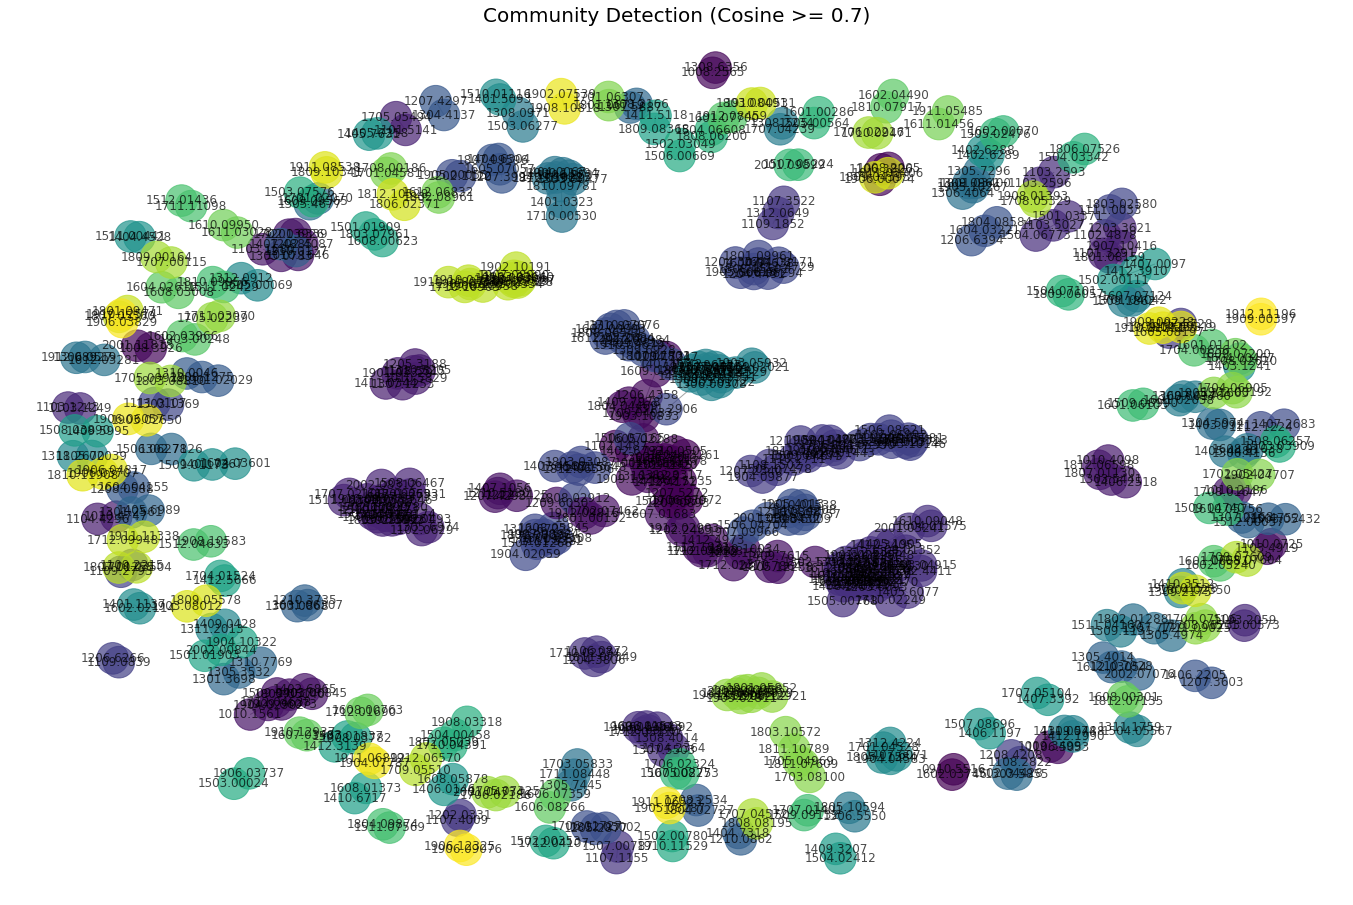

In [ ]:
thres = 0.7
con1 = cs_df['cosine']>=thres
con2 = cs_df['doc1'].isin(filtered_paper['id'])
con3 = cs_df['doc2'].isin(filtered_paper['id'])
temp_df = cs_df[con1&(con2|con3)]
G = nx.convert_matrix.from_pandas_edgelist(temp_df, source='doc1', target='doc2')
G.name = f'Paper Community Detection cosine sim >= {thres}'
print(nx.info(G))
partition = community.best_partition(G, random_state=0)
position = nx.spring_layout(G)
values = [partition.get(node) for node in G.nodes()]

plt.figure(figsize=(24,16))
nx.draw_networkx(G,
                 position,
                 cmap=plt.get_cmap('viridis'),
                 arrows=True,
                 node_color=values, 
                 edge_color='grey',
                 node_size=1000, 
                 with_labels=True, 
                 alpha = 0.7,
                 font_weight='normal')
plt.title(f'Community Detection (Cosine >= {thres})', size=20)
plt.axis('off')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Name: Paper Community Detection cosine sim >= 0.7
Type: Graph
Number of nodes: 191
Number of edges: 244
Average degree:   2.5550


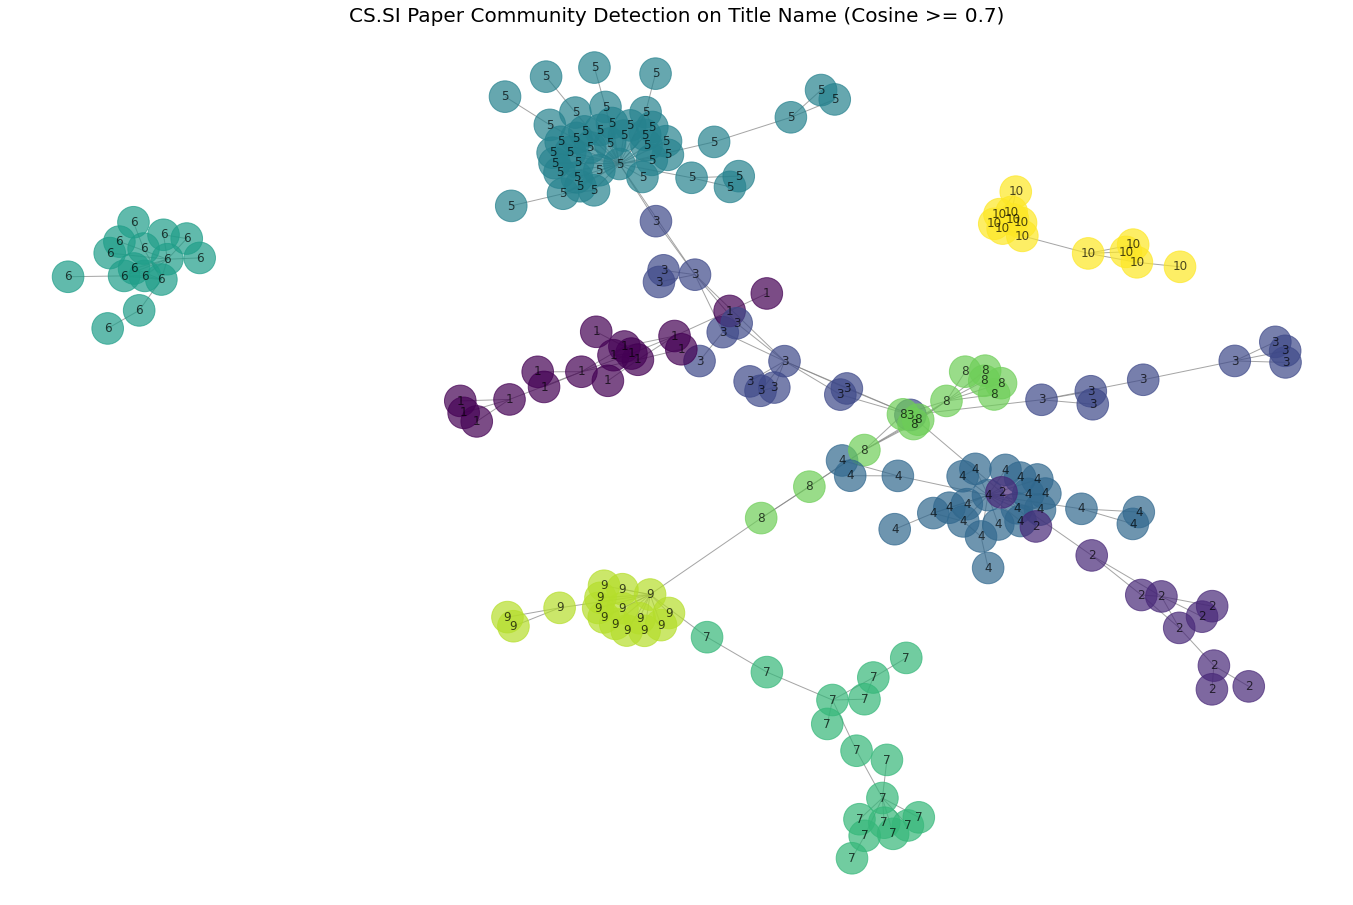

In [ ]:
thres = 0.7
con1 = cs_df['cosine']>=thres
temp_df = cs_df[con1]
G = nx.convert_matrix.from_pandas_edgelist(temp_df, source='doc1', target='doc2')
partition = community.best_partition(G, random_state=0)

paper_cluster = pd.DataFrame({'id' : list(partition.keys()),
                            'cluster' : list(partition.values())})

gb_pp_cluster = paper_cluster.groupby('cluster').count()
gb_pp_cluster.columns = ['n_paper']

#filter n paper in cummunity >= thres
# thres_paper = 10
# gb_pp_cluster = gb_pp_cluster[gb_pp_cluster['n_paper']>= thres_paper]
# print(len(gb_pp_cluster))
# index_cluster = gb_pp_cluster.index


# # Get top 10 cummunities
index_cluster = gb_pp_cluster.sort_values(by='n_paper',ascending=False).head(10).index
filtered_paper = paper_cluster[paper_cluster['cluster'].isin(index_cluster)]

repl_dic = {}
n = 1
for c in filtered_paper['cluster'].unique():
  repl_dic[c] = n
  n += 1

filtered_paper['cluster'] = filtered_paper['cluster'].replace(repl_dic)
con2 = cs_df['doc1'].isin(filtered_paper['id'])
con3 = cs_df['doc2'].isin(filtered_paper['id'])
temp_df2 = temp_df[con2&con3]

G = nx.convert_matrix.from_pandas_edgelist(temp_df2, source='doc1', target='doc2')
G.name = f'Paper Community Detection cosine sim >= {thres}'
print(nx.info(G))
partition = community.best_partition(G, random_state=0)
position = nx.spring_layout(G)

labels = {}
for idx in filtered_paper.index:
  labels[ filtered_paper.loc[idx,'id']] =  str(filtered_paper.loc[idx,'cluster'])

values = [int(labels[node]) for node in G.nodes()]
# print(len(labels))

H=nx.relabel_nodes(G,labels)

plt.figure(figsize=(24,16))

nx.draw_networkx(G,
                 position,
                 labels=labels,
                 cmap=plt.get_cmap('viridis'),
                 node_color=values, 
                 edge_color='grey',
                 node_size=1000, 
                 with_labels=True, 
                 alpha = 0.7,
                 font_weight='normal'
                 )
plt.title(f'CS.SI Paper Community Detection on Title Name (Cosine >= {thres})', size=20)
plt.axis('off')
plt.show()

In [ ]:
temp_df2

doc1        doc2    cosine
28256     1001.3181   1201.4145  0.745356
95421     1009.1731  1609.02622  0.730297
134839    1010.1523   1409.7615  0.750000
134917    1010.1523   1412.4973  0.750000
135963    1010.1523  1712.02370  0.707107
...             ...         ...       ...
6386023  1906.10958  1910.01736  0.750000
6399519  1907.08990  1912.08306  0.707107
6430729  1909.10477  1910.07646  0.816497
6435216  1910.01443  1910.07646  0.755929
6442304  1910.09679  1912.00984  0.750000

[244 rows x 3 columns]

# Iterate LDA each community

In [ ]:
def text_prep(df, col):
  from nltk.tokenize import word_tokenize
  import nltk
  nltk.download('punkt')
  nltk.download('stopwords')
  nltk.download('wordnet')
  from nltk.tokenize import word_tokenize
  from nltk.corpus import stopwords
  from nltk.stem import WordNetLemmatizer
   
  df_clean = df.copy()
  col_new = col+'_new'

  # make lower case
  df_clean[col_new] = df_clean[col].str.lower()

  # remove punctuation
  df_clean[col_new] = df_clean[col_new].str.replace('[^\w\s]','')

  # text tokenization
  df_clean[col_new] = df_clean[col_new].apply(word_tokenize)

  # create lst of English stopwords
  stop_words = stopwords.words('english') 

  # remove stopwords from tokenize
  df_clean['tokenize'] = df_clean[col_new].apply(lambda x: [ word for word in x if word not in stop_words and word[0].isalpha() ])

  # lemmatizing
  lemmatizer = WordNetLemmatizer() 
  df_clean['tokenize'] = df_clean['tokenize'].apply(lambda x: [ lemmatizer.lemmatize(word) for word in x ] )
  df_clean.drop(columns = col_new, inplace = True)

  return df_clean

In [ ]:
filtered_paper2 = filtered_paper.merge(paper[['id','title']], on = 'id', how = 'left')
title_clean = text_prep(filtered_paper2, col = 'title')
# title_clean['tokenize'] = title_clean['tokenize'].apply(lambda x: ' '.join(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
title_clean.head()

id  ...                                           tokenize
0   1001.3181  ...  [weak, tie, subtle, role, information, diffusi...
1   1201.4145  ...    [role, social, network, information, diffusion]
2   1009.1731  ...  [identifying, community, structure, internatio...
3  1609.02622  ...  [identifying, community, structure, dynamic, n...
4   1010.1523  ...           [fuzzy, overlapping, community, network]

[5 rows x 4 columns]

In [ ]:
title_clean['cluster'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
dictionary = Dictionary(title_clean['tokenize'])
dictionary.filter_extremes(no_below=15, no_above=0.9, keep_n=2000)
bow_corpus = [dictionary.doc2bow(doc) for doc in title_clean['tokenize']]

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=2, id2word=dictionary, passes=2, workers=2)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.205*"complex" + 0.200*"temporal" + 0.147*"social" + 0.100*"multilayer" + 0.092*"information" + 0.082*"centrality" + 0.062*"dynamic" + 0.030*"graph" + 0.027*"community" + 0.026*"structure"
Topic: 1 
Words: 0.257*"community" + 0.145*"detection" + 0.117*"structure" + 0.095*"graph" + 0.087*"overlapping" + 0.076*"dynamic" + 0.071*"social" + 0.069*"complex" + 0.028*"multilayer" + 0.027*"centrality"


In [ ]:
title_clean.shape

(191, 4)

In [ ]:
lst_topic = []
lst_prob = []
lst_cluster = []
for cluster in title_clean['cluster'].unique():
  # iterate each cluster
  temp_lda = title_clean[title_clean['cluster']==cluster]

  # LDA
  dictionary = Dictionary(temp_lda['tokenize'])
  # dictionary.filter_extremes(no_below=15, no_above=0.9, keep_n=2000)
  bow_corpus = [dictionary.doc2bow(doc) for doc in temp_lda['tokenize']]
  lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=1, id2word=dictionary, passes=2, workers=2)
  for idx, topic in lda_model.print_topics(-1):
    splited_topic = topic.split('+')

    for tp in splited_topic:
      prob, t = [i.replace('"','').strip() for i in tp.split('*')]
      lst_topic.append(t)
      lst_prob.append(float(prob))
      lst_cluster.append(cluster)

In [ ]:
result_lda = pd.DataFrame({'cluster':lst_cluster,
                           'topic': lst_topic,
                           'prob': lst_prob})
result_lda

cluster          topic   prob
0         1         social  0.136
1         1        network  0.129
2         1    information  0.121
3         1      diffusion  0.091
4         1        dynamic  0.053
..      ...            ...    ...
95       10       directed  0.025
96       10        dynamic  0.025
97       10     generative  0.025
98       10   multichannel  0.025
99       10  spectralbased  0.025

[100 rows x 3 columns]

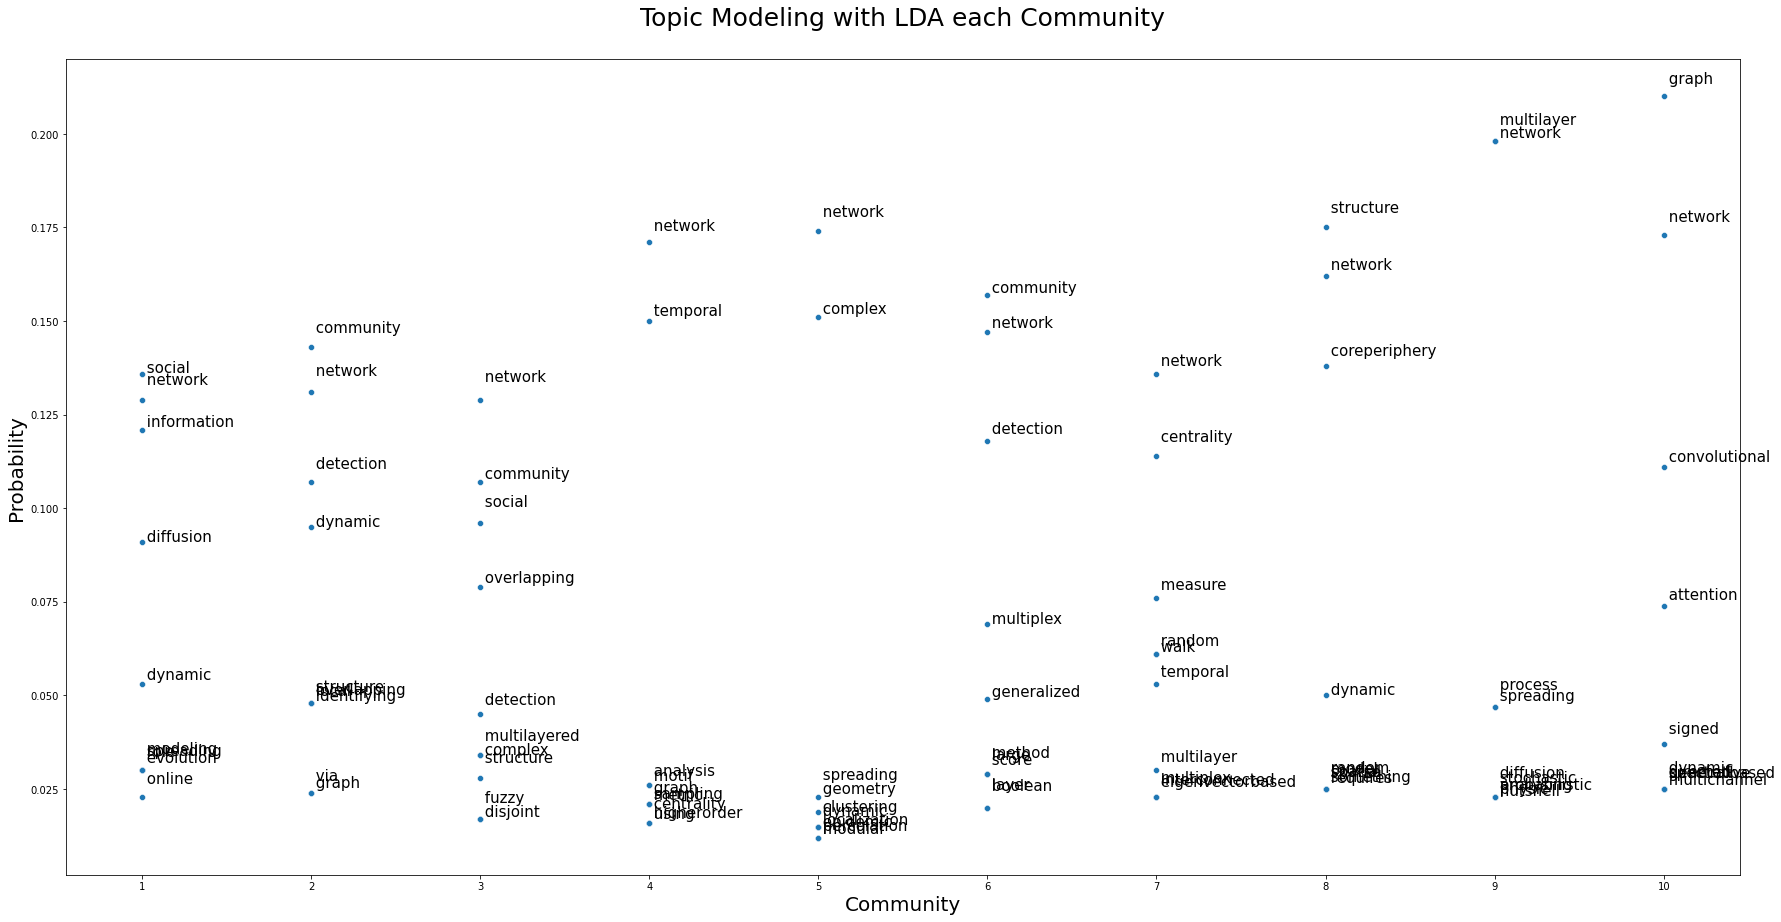

In [ ]:
fig, ax = plt.subplots(figsize=(30,15))
sns.scatterplot(x='cluster', y='prob', data = result_lda, ax = ax)
for idx in result_lda.index:
  ax.annotate(f" {result_lda.loc[idx, 'topic']}",
              xy=(result_lda.loc[idx, 'cluster'], result_lda.loc[idx,'prob'] + np.random.rand()/200), 
              size=15)
plt.title('Topic Modeling with LDA each Community\n', size = 25)
plt.xticks(result_lda['cluster'].unique(), size=10)
plt.xlabel('Community', size=20)
plt.ylabel('Probability', size=20)
plt.show()

In [ ]:
for cluster in result_lda['cluster'].unique():
  # iterate each cluster
  temp_lda = result_lda[result_lda['cluster']==cluster]
  display(temp_lda.head(10))

cluster        topic   prob
0        1       social  0.136
1        1      network  0.129
2        1  information  0.121
3        1    diffusion  0.091
4        1      dynamic  0.053
5        1         role  0.030
6        1    evolution  0.030
7        1     modeling  0.030
8        1    spreading  0.030
9        1       online  0.023

cluster        topic   prob
10        2    community  0.143
11        2      network  0.131
12        2    detection  0.107
13        2      dynamic  0.095
14        2        local  0.048
15        2  identifying  0.048
16        2  overlapping  0.048
17        2    structure  0.048
18        2        graph  0.024
19        2          via  0.024

cluster         topic   prob
20        3       network  0.129
21        3     community  0.107
22        3        social  0.096
23        3   overlapping  0.079
24        3     detection  0.045
25        3  multilayered  0.034
26        3       complex  0.034
27        3     structure  0.028
28        3      disjoint  0.017
29        3         fuzzy  0.017

cluster        topic   prob
30        4      network  0.171
31        4     temporal  0.150
32        4        motif  0.026
33        4     analysis  0.026
34        4       metric  0.021
35        4     sampling  0.021
36        4        graph  0.021
37        4        using  0.016
38        4   centrality  0.016
39        4  higherorder  0.016

cluster         topic   prob
40        5       network  0.174
41        5       complex  0.151
42        5     spreading  0.023
43        5      geometry  0.019
44        5    clustering  0.015
45        5       dynamic  0.015
46        5      epidemic  0.015
47        5  localization  0.015
48        5   percolation  0.012
49        5       modular  0.012

cluster        topic   prob
50        6    community  0.157
51        6      network  0.147
52        6    detection  0.118
53        6    multiplex  0.069
54        6  generalized  0.049
55        6        score  0.029
56        6        large  0.029
57        6       method  0.029
58        6      boolean  0.020
59        6        layer  0.020

cluster             topic   prob
60        7           network  0.136
61        7        centrality  0.114
62        7           measure  0.076
63        7            random  0.061
64        7              walk  0.061
65        7          temporal  0.053
66        7        multilayer  0.030
67        7         multiplex  0.023
68        7    interconnected  0.023
69        7  eigenvectorbased  0.023

cluster          topic   prob
70        8      structure  0.175
71        8        network  0.162
72        8  coreperiphery  0.138
73        8        dynamic  0.050
74        8         random  0.025
75        8      something  0.025
76        8          model  0.025
77        8       requires  0.025
78        8         sparse  0.025
79        8        spatial  0.025

cluster          topic   prob
80        9        network  0.198
81        9     multilayer  0.198
82        9        process  0.047
83        9      spreading  0.047
84        9      analysing  0.023
85        9      diffusion  0.023
86        9     stochastic  0.023
87        9  probabilistic  0.023
88        9       nutshell  0.023
89        9         physic  0.023

cluster          topic   prob
90       10          graph  0.210
91       10        network  0.173
92       10  convolutional  0.111
93       10      attention  0.074
94       10         signed  0.037
95       10       directed  0.025
96       10        dynamic  0.025
97       10     generative  0.025
98       10   multichannel  0.025
99       10  spectralbased  0.025

In [ ]:
result_lda.to_csv('result_lda.csv',index=False)

In [ ]:
title_clean.drop(columns = 'tokenize').to_csv('focus_paper.csv',index=False)

In [ ]:
title_clean

id  ...                                           tokenize
0     1001.3181  ...  [weak, tie, subtle, role, information, diffusi...
1     1201.4145  ...    [role, social, network, information, diffusion]
2     1009.1731  ...  [identifying, community, structure, internatio...
3    1609.02622  ...  [identifying, community, structure, dynamic, n...
4     1010.1523  ...           [fuzzy, overlapping, community, network]
..          ...  ...                                                ...
186  1907.08990  ...  [spectralbased, graph, convolutional, network,...
187  1912.08306  ...      [multichannel, graph, convolutional, network]
188  1902.10191  ...  [evolvegcn, evolving, graph, convolutional, ne...
189  1909.10477  ...  [community, detection, improved, detectability...
190  1910.01443  ...  [efficient, community, detection, boolean, com...

[191 rows x 4 columns]

In [ ]:
filtered_paper.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191 entries, 5 to 662
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       191 non-null    object
 1   cluster  191 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB


In [ ]:
paper_cluster = pd.DataFrame({'id' : list(partition.keys()),
                            'cluster' : list(partition.values())})
paper_cluster['id'] = paper_cluster['id'].astype(str)
gb_pp_cluster = paper_cluster.groupby('cluster').count()
gb_pp_cluster.columns = ['n_paper']

#filter n paper in cummunity >= thres
# thres_paper = 10
# gb_pp_cluster = gb_pp_cluster[gb_pp_cluster['n_paper']>= thres_paper]

print(len(gb_pp_cluster))
index_cluster = gb_pp_cluster.sort_values(by='n_paper',ascending=False).head(10).index
# index_cluster = gb_pp_cluster.index
filtered_paper = paper_cluster[paper_cluster['cluster'].isin(index_cluster)]
filtered_paper.head()

10


id  cluster
0   1001.3181        0
1   1201.4145        0
2   1009.1731        1
3  1609.02622        1
4   1010.1523        2

In [ ]:
filtered_paper['cluster'].nunique()

10

Name: Paper Community Detection cosine sim >= 0.7
Type: Graph
Number of nodes: 169
Number of edges: 204
Average degree:   2.4142


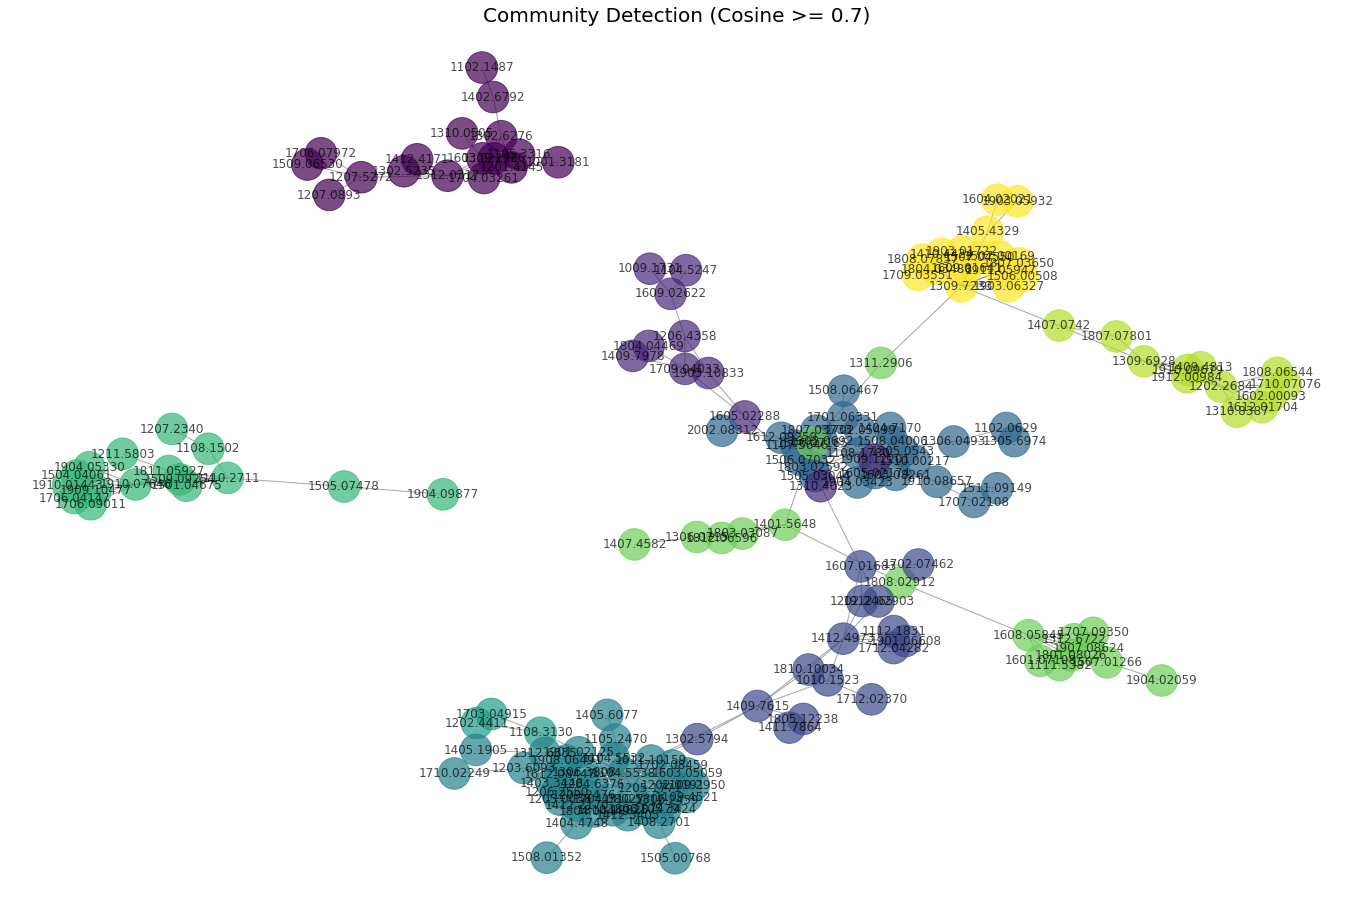

In [ ]:
thres = 0.7
con1 = cs_df['cosine']>=thres
con2 = cs_df['doc1'].isin(filtered_paper['id'])
con3 = cs_df['doc2'].isin(filtered_paper['id'])
temp_df = cs_df[con1&(con2|con3)]
G = nx.convert_matrix.from_pandas_edgelist(temp_df, source='doc1', target='doc2')
G.name = f'Paper Community Detection cosine sim >= {thres}'
print(nx.info(G))

partition = community.best_partition(G, random_state=0)
position = nx.spring_layout(G)
values = [partition.get(node) for node in G.nodes()]
plt.figure(figsize=(24,16))
nx.draw_networkx(G,
                 position,
                 cmap=plt.get_cmap('viridis'),
                 arrows=True,
                 node_color=values, 
                 edge_color='grey',
                 node_size=1000, 
                 with_labels=True, 
                 alpha = 0.7,
                 font_weight='normal')
plt.title(f'Community Detection (Cosine >= {thres})', size=20)
plt.axis('off')
plt.show()

In [ ]:
filtered_paper.shape

(166, 2)

In [ ]:
filtered_paper

id  cluster
0     1001.3181        0
1     1201.4145        0
2     1009.1731        1
3    1609.02622        1
4     1010.1523        2
..          ...      ...
173  1706.09011        6
174  1707.02108        3
175  1804.04469        1
189  1909.10477        6
190  1910.01443        6

[166 rows x 2 columns]

In [ ]:
filtered_paper['cluster'].nunique()

9

In [ ]:
print(filtered_paper['cluster'].unique())
repl_dic = {}

clus = 1
for i in filtered_paper['cluster'].unique():
  repl_dic[i] = clus
  clus += 1
filtered_paper['cluster'] = filtered_paper['cluster'].replace(repl_dic)
print(repl_dic)

[ 0  1  2  3  4  6  7  8 10]
{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 6: 6, 7: 7, 8: 8, 10: 9}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# filtered_paper.drop(columns = 'cluster_clean',inplace=True)
filtered_paper.head()

id  cluster
0   1001.3181        1
1   1201.4145        1
2   1009.1731        2
3  1609.02622        2
4   1010.1523        3

In [ ]:
filtered_paper.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 0 to 190
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       166 non-null    object
 1   cluster  166 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.9+ KB


In [ ]:
cs_paper = paper[paper['categories'].apply(lambda x: True if 'cs.' in x else False)]

In [ ]:
cs_paper['id'] = cs_paper['id'].astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
filtered_paper['id']

2       1001.3181
3       1201.4145
11      1009.1731
12     1609.02622
17      1010.1523
          ...    
582    1907.08990
583    1912.08306
603    1902.10191
621    1909.10477
622    1910.01443
Name: id, Length: 211, dtype: object

In [ ]:
cs_paper_tt = cs_paper[['id','title']].copy()
cs_paper_tt_cluster = cs_paper_tt.merge(filtered_paper, on = 'id', how = 'inner')
cs_paper_tt_cluster.head()

id                                              title  cluster
0  1001.3181  Weak ties: Subtle role of information diffusio...        1
1  1009.1731  Identifying the Community Structure of the Int...        2
2  1010.1523          Fuzzy overlapping communities in networks        3
3  1102.0629  Time-Varying Graphs and Social Network Analysi...        4
4  1102.1487                 Rumor Evolution in Social Networks        1

In [ ]:
cs_paper_tt_cluster.shape

(166, 3)

In [ ]:
title_clean = text_prep(cs_paper_tt_cluster, col = 'title')
title_clean['tokenize'] = title_clean['tokenize'].apply(lambda x: ' '.join(x))
title_clean.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


id  ...                                           tokenize
0  1001.3181  ...  weak tie subtle role information diffusion onl...
1  1009.1731  ...  identifying community structure internationalt...
2  1010.1523  ...                fuzzy overlapping community network
3  1102.0629  ...  timevarying graph social network analysis temp...
4  1102.1487  ...                     rumor evolution social network

[5 rows x 4 columns]

In [ ]:
vectorizer = TfidfVectorizer()
bow_df = vectorizer.fit_transform(title_clean['tokenize'])
bow_df = pd.DataFrame(bow_df.toarray() , columns = vectorizer.get_feature_names())
bow_df['id'] = cs_paper_tt_cluster['id'].values
bow_df_melt = bow_df.melt(id_vars = 'id', var_name= 'word', value_name= 'tfidf')
bow_df_melt = bow_df_melt[bow_df_melt['tfidf'] > 0 ]
bow_df_melt.shape

(828, 3)

In [ ]:
bow_df_melt

id         word     tfidf
120    1707.09350   accounting  0.509022
258    1510.00217     adaptive  0.448593
341     1105.3316     affinity  0.584162
587    1508.06467    aggregate  0.483169
695     1207.0893  aggregation  0.577330
...           ...          ...       ...
41312  1812.06596         walk  0.455915
41334   1001.3181         weak  0.419177
41614  1704.03261       wechat  0.520493
41800  1806.07479       weight  0.671111
41909  1504.04061          z_2  0.451707

[828 rows x 3 columns]

In [ ]:
# bow_df_melt.to_csv('/content/drive/My Drive/Big Data Analytics & Social/spectral_clustering_group_keywords.csv',index=False)

In [ ]:
# title_clean.to_csv('/content/drive/My Drive/Big Data Analytics & Social/spectral_clustering_group.csv',index=False)

In [ ]:
word_with_cluster = bow_df_melt.merge(title_clean[['id','cluster']], on = 'id', how = 'inner')
word_with_cluster = word_with_cluster.groupby(['cluster','word']).agg({'tfidf':'max',
                                                                        'id':'count'}).reset_index() 

word_with_cluster.rename(columns = {'id':'freq'},inplace=True)
word_with_cluster.head()

cluster          word     tfidf  freq
0        1      affinity  0.584162     1
1        1   aggregation  0.577330     1
2        1   application  0.481590     1
3        1     curiosity  0.568835     1
4        1  differential  0.419177     1

In [ ]:
word_with_cluster['freq'].value_counts()

1     245
2      26
3      19
4       4
14      4
16      3
6       3
11      3
7       3
8       2
5       2
10      2
12      2
15      2
17      2
25      2
9       1
37      1
13      1
39      1
Name: freq, dtype: int64

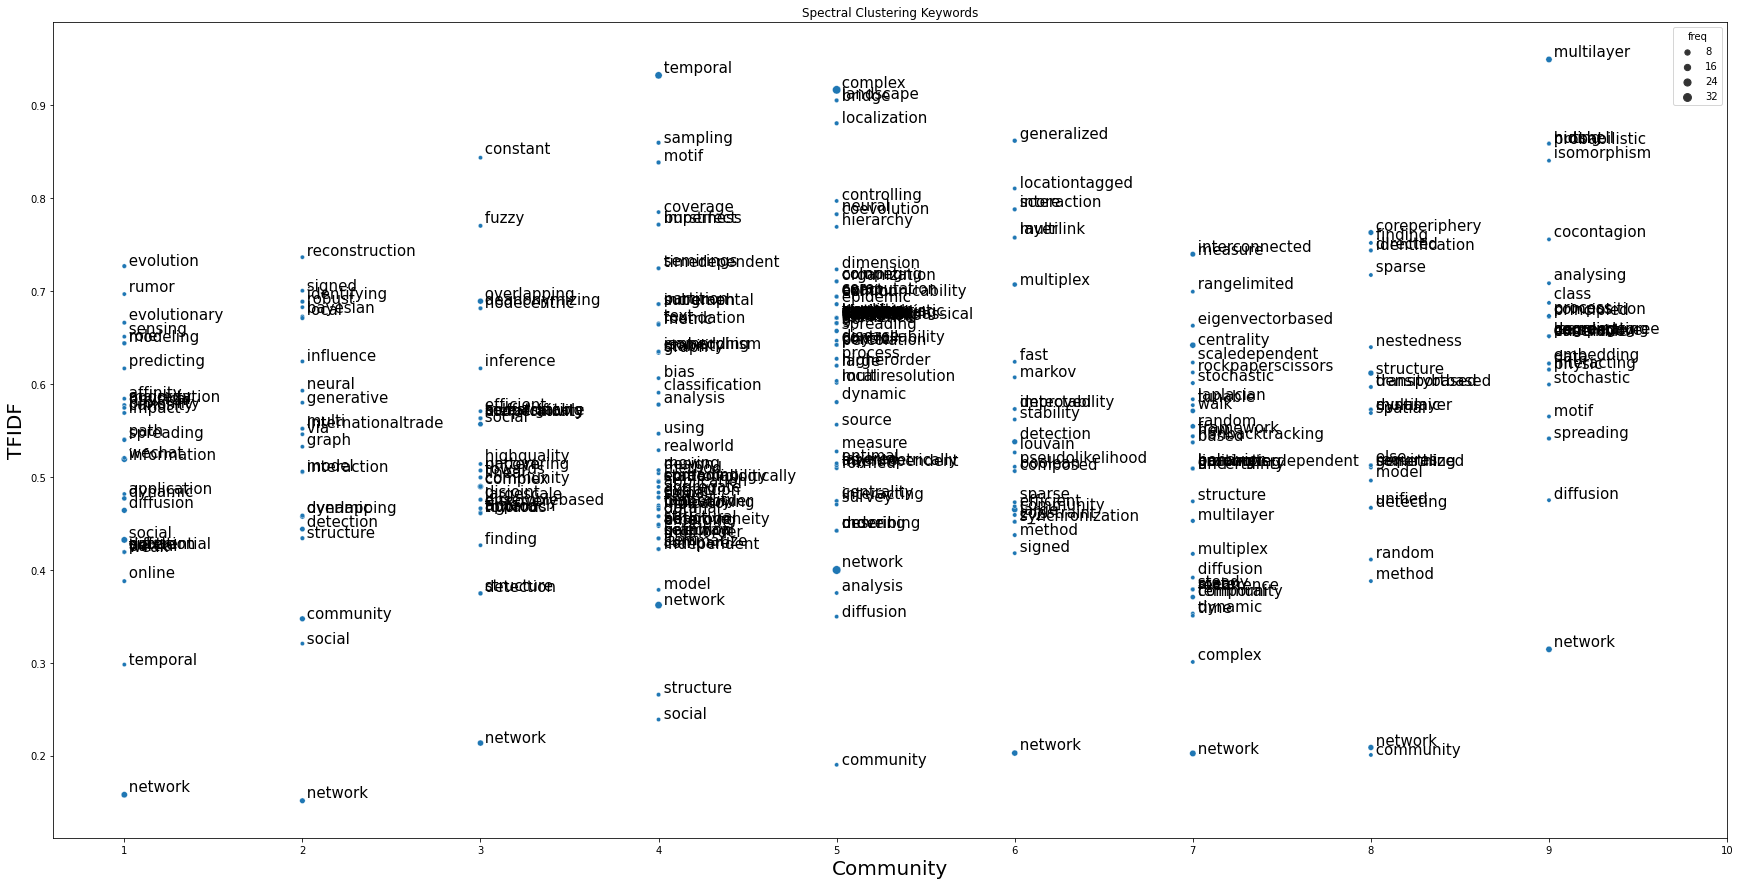

In [ ]:
fig, ax = plt.subplots(figsize=(30,15))
sns.scatterplot(x='cluster', y='tfidf', data = word_with_cluster, ax = ax, size = 'freq')
for idx in word_with_cluster.index:
  ax.annotate(f" {word_with_cluster.loc[idx, 'word']}",
              xy=(word_with_cluster.loc[idx, 'cluster'], word_with_cluster.loc[idx,'tfidf']+ np.random.rand()/200),
              size=15)
plt.title('Spectral Clustering Keywords')
plt.xticks(result_lda['cluster'].unique(), size=10)
plt.xlabel('Community', size=20)
plt.ylabel('TFIDF', size=20)
plt.show()


# Combine Cluster both of GraphSAGE and Spectral Clustering

In [ ]:
gsage = pd.read_csv('/content/drive/MyDrive/Big Data Analytics & Social/si_6k_output_tfidf.csv')
gsage.head()

id  ... Page Rank
0  0710.4982  ...  2.233176
1  0803.2443  ...  3.055294
2  0806.4168  ...  1.205529
3  0807.1550  ...  2.081263
4  0809.0522  ...  4.072664

[5 rows x 21 columns]

In [ ]:
gsage.shape

(6832, 21)

In [ ]:
gsage['label'].value_counts()

7    1201
4     727
6     716
0     709
2     688
9     676
8     645
3     632
5     475
1     363
Name: label, dtype: int64

In [ ]:
paper_cluster['cluster'].value_counts()

4    37
3    25
7    17
0    17
9    16
6    16
2    15
8    12
1    11
5     3
Name: cluster, dtype: int64

In [ ]:
paper_cluster.head()

id  cluster
0   1001.3181        0
1   1201.4145        0
2   1009.1731        1
3  1609.02622        1
4   1010.1523        2

In [ ]:
combine_two_method = paper_cluster.merge(gsage[['id','label']], left_on = 'id', right_on = 'id', how = 'left')
combine_two_method.columns = ['id', 'spectral_label', 'graphsage_label']

In [ ]:
pv_df = combine_two_method.pivot_table(index='spectral_label', columns = 'graphsage_label', values = 'id', aggfunc='count').fillna(0)
pv_df

graphsage_label    0    1    2    3     4    5    6    7     8    9
spectral_label                                                     
0                3.0  0.0  3.0  5.0   0.0  1.0  0.0  1.0   4.0  0.0
1                0.0  2.0  2.0  0.0   6.0  0.0  0.0  0.0   0.0  1.0
2                0.0  2.0  3.0  0.0   9.0  0.0  0.0  0.0   0.0  1.0
3                0.0  3.0  1.0  0.0   2.0  0.0  0.0  1.0   9.0  9.0
4                1.0  3.0  5.0  3.0   4.0  0.0  1.0  9.0   8.0  3.0
5                0.0  0.0  0.0  0.0   0.0  0.0  0.0  3.0   0.0  0.0
6                0.0  1.0  1.0  0.0  11.0  0.0  0.0  1.0   2.0  0.0
7                0.0  2.0  2.0  3.0   2.0  0.0  1.0  0.0   6.0  1.0
8                0.0  0.0  4.0  0.0   6.0  0.0  0.0  0.0   2.0  0.0
9                0.0  1.0  0.0  0.0   2.0  0.0  0.0  0.0  11.0  2.0

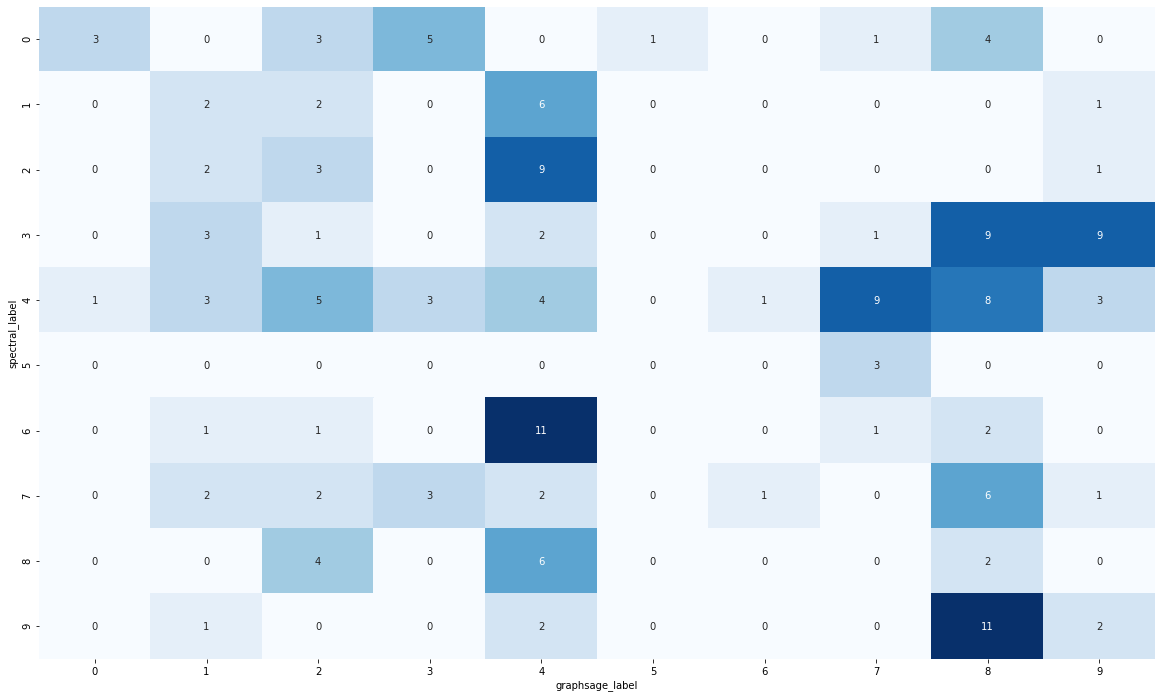

In [ ]:
plt.figure(figsize=(20,12))
sns.heatmap(pv_df, annot = True, fmt = 'g', cmap = 'Blues', cbar = False)